# Data Utility for Synthetic Data Evaluation

This serves the following purposes: 
- viewing all MRI volumes generated by the diffusion model.
- constructing training datasets with different amounts of real and synthetic data.

## View All Synthetic Volumes

Used for determining poor-quality MRI

Found NIfTI files for modalities: t1n, t1c, t2w, t2f

Case 1:
T1N: BraTS-GLI-00005-100_t1n_synth.nii.gz
T1C: BraTS-GLI-00005-100_t1c_synth.nii.gz
T2W: BraTS-GLI-00005-100_t2w_synth.nii.gz
T2F: BraTS-GLI-00005-100_t2f_synth.nii.gz


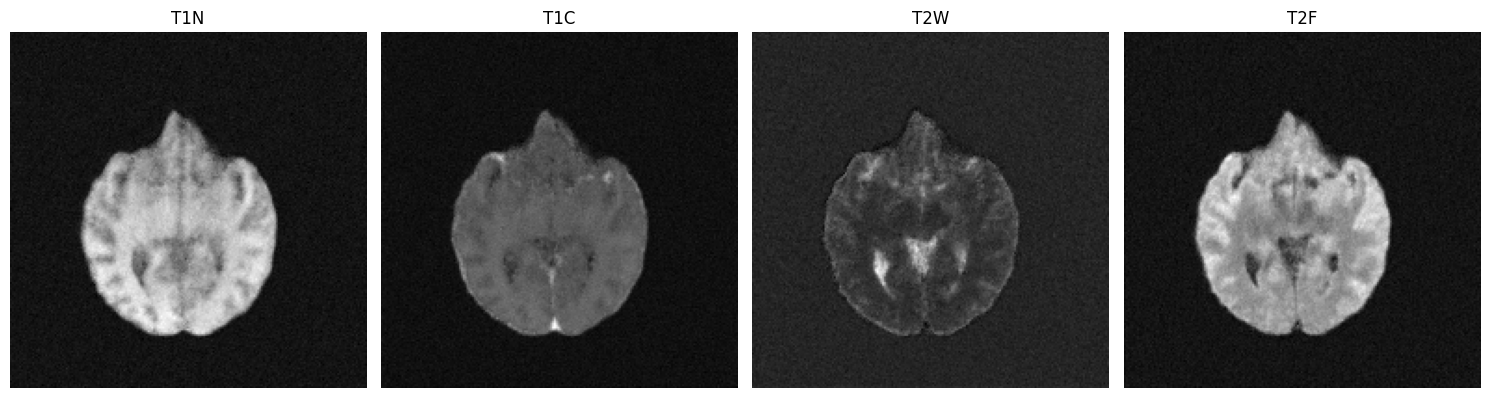


Case 2:
T1N: BraTS-GLI-00005-100_t1n_synth2.nii.gz
T1C: BraTS-GLI-00005-100_t1c_synth2.nii.gz


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fa70fc61a50>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


T2W: BraTS-GLI-00005-100_t2w_synth2.nii.gz


KeyboardInterrupt: 

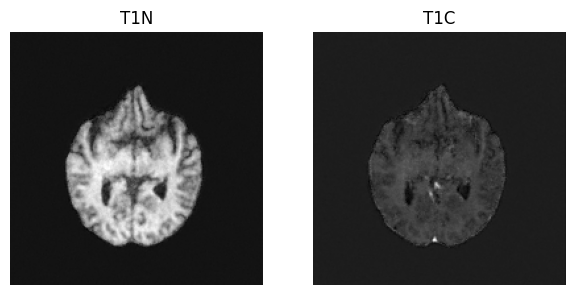

In [9]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

nifti_folder = '../../data/BraTS2024-GLI-Synthetic'

if not os.path.isdir(nifti_folder):
    raise NotADirectoryError(f"The specified folder does not exist: {nifti_folder}")

# Define the modalities (subfolder names)
modalities = ['t1n', 't1c', 't2w', 't2f']

# Gather file paths for each modality
modality_files = {mod: sorted(glob(os.path.join(nifti_folder, mod, '*.nii')) +
                              glob(os.path.join(nifti_folder, mod, '*.nii.gz')))
                  for mod in modalities}

# Check if files exist for all modalities
for mod, files in modality_files.items():
    if not files:
        raise FileNotFoundError(f"No NIfTI files found for modality: {mod}")

print(f"Found NIfTI files for modalities: {', '.join(modalities)}")

def plot_modalities_side_by_side(modality_files, modalities, plane='axial', figsize=(15, 5)):
    """
    Plots middle slices for all modalities side by side for each patient/case, and prints the file names.

    Parameters:
    - modality_files (dict): Dictionary of modality file paths.
    - modalities (list): List of modality names.
    - plane (str): Anatomical plane to extract the slice from ('axial', 'sagittal', 'coronal').
    - figsize (tuple): Size of the matplotlib figure.
    """
    # Iterate over the files for the first modality as the reference
    num_cases = len(modality_files[modalities[0]])
    for i in range(num_cases):
        print(f"\nCase {i + 1}:")
        plt.figure(figsize=figsize)
        
        for j, mod in enumerate(modalities):
            try:
                # Get the file path and print the name
                file_path = modality_files[mod][i]
                print(f"{mod.upper()}: {os.path.basename(file_path)}")
                
                # Load the NIfTI file for the modality
                img = nib.load(file_path)
                data = img.get_fdata()

                # Extract the middle slice based on the chosen plane
                if plane == 'axial':
                    slice_idx = data.shape[2] // 2
                    slice_data = data[:, :, slice_idx]
                elif plane == 'sagittal':
                    slice_idx = data.shape[0] // 2
                    slice_data = data[slice_idx, :, :]
                elif plane == 'coronal':
                    slice_idx = data.shape[1] // 2
                    slice_data = data[:, slice_idx, :]
                else:
                    raise ValueError("Invalid plane. Choose from 'axial', 'sagittal', or 'coronal'.")

                # Plot the slice
                plt.subplot(1, len(modalities), j + 1)
                plt.imshow(np.rot90(slice_data), cmap='gray')
                plt.title(f"{mod.upper()}")
                plt.axis('off')
            except Exception as e:
                print(f"Error processing {modality_files[mod][i]}: {e}")

        # Adjust layout and show the figure
        plt.tight_layout()
        plt.show()

# Plot all modalities side by side for each patient/case and print their file names
plot_modalities_side_by_side(modality_files, modalities, plane='axial')

## Prepare Dataset 001 with All $N=1062$ Synthetic Samples and Original Data for nnU-Net 

### Definitions

In [3]:
!pip install nibabel numpy
import os
import shutil
import json
import re
from pathlib import Path
import nibabel as nib
import numpy as np

#########################################
# Define paths
#########################################
synthetic_dataset_dir = "../../data/BraTS2024-GLI-Synthetic/"
original_dataset_dir = "../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal"
merged_dataset_dir = "../../data/4_gli_augmented"
nnunet_raw_dir = "nnUNet/nnUNet_raw"
dataset_id = "Dataset001_GliHeadMaskSynth"

#########################################
# Remove previous merged dataset if it exists
#########################################
if os.path.exists(merged_dataset_dir) and os.path.isdir(merged_dataset_dir):
    shutil.rmtree(merged_dataset_dir)
    print(f"{merged_dataset_dir} has been deleted. ✅")
else:
    print(f"{merged_dataset_dir} does not exist. ✅")

#########################################
# Remove only the specific dataset folder within nnUNet_raw
#########################################
nnunet_dataset_path = os.path.join(nnunet_raw_dir, dataset_id)
if os.path.exists(nnunet_dataset_path) and os.path.isdir(nnunet_dataset_path):
    shutil.rmtree(nnunet_dataset_path)
    print(f"{nnunet_dataset_path} has been deleted. ✅")
else:
    print(f"{nnunet_dataset_path} does not exist. ✅")

../../data/4_gli_augmented has been deleted. ✅
('nnUNet/nnUNet_raw', 'Dataset001_GliHeadMaskSynth') has been deleted. ✅


### Merge Original and Synthetic Datasets

In [5]:
train_modalities_original = [f"train_{m}" for m in ["seg", "t1n", "t1c", "t2w", "t2f"]]
modalities_synth = ["seg", "t1n", "t1c", "t2w", "t2f"]

for orig_dirname, modality in zip(train_modalities_original, modalities_synth):
    src_dir_orig = Path(original_dataset_dir) / orig_dirname
    src_dir_synth = Path(synthetic_dataset_dir) / modality
    dst_dir = Path(merged_dataset_dir) / orig_dirname
    dst_dir.mkdir(parents=True, exist_ok=True)

    if src_dir_orig.exists() and src_dir_orig.is_dir():
        original_files = list(src_dir_orig.glob("*.nii.gz"))
        print(f"Copying {len(original_files)} original files from '{src_dir_orig}' to '{dst_dir}'")
        for file in original_files:
            shutil.copy2(file, dst_dir / file.name)
            print(f"  Copied original: '{file.name}'")
    else:
        print(f"Original training directory does not exist: {src_dir_orig}")

    if src_dir_synth.exists() and src_dir_synth.is_dir():
        synthetic_files = list(src_dir_synth.glob("*.nii.gz"))
        print(f"Copying {len(synthetic_files)} synthetic files from '{src_dir_synth}' to '{dst_dir}'")
        for file in synthetic_files:
            shutil.copy2(file, dst_dir / file.name)
            print(f"  Copied synthetic: '{file.name}'")
    else:
        print(f"Synthetic training directory does not exist: {src_dir_synth}")

    print()

# Process validation data (only original files are used)
val_modalities_original = [f"val_{m}" for m in ["seg", "t1n", "t1c", "t2w", "t2f"]]
for dirname in val_modalities_original:
    src_dir_orig = Path(original_dataset_dir) / dirname
    dst_dir = Path(merged_dataset_dir) / dirname
    dst_dir.mkdir(parents=True, exist_ok=True)

    if src_dir_orig.exists() and src_dir_orig.is_dir():
        original_files = list(src_dir_orig.glob("*.nii.gz"))
        print(f"Copying {len(original_files)} original validation files from '{src_dir_orig}' to '{dst_dir}'")
        for file in original_files:
            shutil.copy2(file, dst_dir / file.name)
            print(f"  Copied validation: '{file.name}'")
    else:
        print(f"Original validation directory does not exist: {src_dir_orig}")

    print()

Copying 1235 original files from '../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_seg' to '../../data/4_gli_augmented/train_seg'
  Copied original: 'BraTS-GLI-00005-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00005-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00006-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00006-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00008-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00008-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00008-102_seg.nii.gz'
  Copied original: 'BraTS-GLI-00008-103_seg.nii.gz'
  Copied original: 'BraTS-GLI-00009-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00009-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00020-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00020-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00027-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00033-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00046-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00033-101_seg.nii.gz'
  Copied original:

### Convert Dataset to nnU-Net Format

In [6]:
modality_suffixes = {
    "_t1n": "0000",
    "_t1c": "0001", 
    "_t2w": "0002",
    "_t2f": "0003"
}

# Create target directories for nnU-Net
target_base = os.path.join(nnunet_raw_dir, dataset_id)
dirs_to_create = [
    os.path.join(target_base, "imagesTr"),
    os.path.join(target_base, "labelsTr"),
    os.path.join(target_base, "imagesTs"),
    os.path.join(target_base, "labelsTs")
]
for d in dirs_to_create:
    os.makedirs(d, exist_ok=True)

def process_filename(fname, is_seg=False):
    """
    Convert filename to nnU-Net case_id and modality code.
    The conversion (e.g. adding/removing '_synth') is applied on the merged copy,
    leaving the original synthetic filenames unchanged.
    """
    if "_synth" in fname:
        base = fname.replace("_synth.nii.gz", "").replace(".nii.gz", "")
        synth = "_synth"
    else:
        base = fname.replace(".nii.gz", "")
        synth = ""

    if not is_seg:
        for suffix, code in modality_suffixes.items():
            if base.endswith(suffix):
                case_id = base.replace(suffix, "") + synth
                return case_id, code
    case_id = base.replace("_seg", "") + synth
    return case_id, None

def process_label_file(file_path):
    """
    Round segmentation labels to integers, ensure correct dtype, and match the image's affine.
    """
    try:
        seg_img = nib.load(file_path)
        seg_data = seg_img.get_fdata()
        seg_data = np.round(seg_data).astype(np.int16)
        
        unique_labels = np.unique(seg_data)
        valid_labels = {0, 1, 2, 3, 4, 5}
        if not set(unique_labels).issubset(valid_labels):
            raise ValueError(f"Invalid labels found: {unique_labels}")
            
        case_id = os.path.basename(file_path).replace('.nii.gz', '')
        if 'labelsTr' in file_path:
            img_dir = os.path.join(os.path.dirname(os.path.dirname(file_path)), 'imagesTr')
        else:
            img_dir = os.path.join(os.path.dirname(os.path.dirname(file_path)), 'imagesTs')
        
        img_path = os.path.join(img_dir, f"{case_id}_0000.nii.gz")
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file {img_path} not found for case {case_id}")
        
        img_img = nib.load(img_path)
        img_affine = img_img.affine
        
        new_seg_img = nib.Nifti1Image(seg_data, img_affine, seg_img.header)
        nib.save(new_seg_img, file_path)
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

# Process training and validation data: move and rename files from the merged folder to the nnU-Net target directories.
for split in ["train", "val"]:
    img_target = os.path.join(target_base, "imagesTr" if split == "train" else "imagesTs")
    seg_target = os.path.join(target_base, "labelsTr" if split == "train" else "labelsTs")

    # Process images (non-segmentation files)
    for mod_suffix, code in modality_suffixes.items():
        mod_dir = os.path.join(merged_dataset_dir, f"{split}{mod_suffix}")
        if os.path.exists(mod_dir):
            for fname in os.listdir(mod_dir):
                if fname.endswith(".nii.gz"):
                    src = os.path.join(mod_dir, fname)
                    case_id, _ = process_filename(fname)
                    dst = os.path.join(img_target, f"{case_id}_{code}.nii.gz")
                    if not os.path.exists(dst):
                        shutil.move(src, dst)

    # Process segmentation files
    seg_dir = os.path.join(merged_dataset_dir, f"{split}_seg")
    if os.path.exists(seg_dir):
        for fname in os.listdir(seg_dir):
            if fname.endswith(".nii.gz"):
                src = os.path.join(seg_dir, fname)
                case_id, _ = process_filename(fname, is_seg=True)
                dst = os.path.join(seg_target, f"{case_id}.nii.gz")
                if not os.path.exists(dst):
                    shutil.move(src, dst)
                process_label_file(dst)

# Create dataset.json for nnU-Net
dataset_json = {
    "channel_names": {v: k.replace("_", "") for k, v in modality_suffixes.items()},
    "labels": {
        "background": 0,
        "head": 1,
        "enhancing_tissue": 2,
        "non_enhancing_tumor_core": 3,
        "surrounding_non_enhancing_FLAIR_hyperintensity": 4,
        "resection_cavity": 5
    },
    "numTraining": len(os.listdir(os.path.join(target_base, "labelsTr"))),
    "numTest": len(os.listdir(os.path.join(target_base, "labelsTs"))),
    "file_ending": ".nii.gz",
    "overwrite_image_reader_writer": "NibabelIO"
}

with open(os.path.join(target_base, "dataset.json"), "w") as f:
    json.dump(dataset_json, f, indent=4)

print("Dataset conversion complete with validated integer labels.")

Dataset conversion complete with validated integer labels.


### Orientate Masks Properly

In [10]:
labelsTr_dir = os.path.join(target_base, "labelsTr")
synth_seg_files = [f for f in os.listdir(labelsTr_dir)
                   if f.endswith('.nii.gz') and ('synth' in f)]

for seg_file in synth_seg_files:
    seg_path = os.path.join(labelsTr_dir, seg_file)
    try:
        seg_img = nib.load(seg_path)
        seg_data = seg_img.get_fdata()
        # Flip the segmentation volume along the x-axis (axis 0)
        seg_data_flipped = np.flip(seg_data, axis=0)
        # Round and cast to integer type (np.int16)
        seg_data_flipped = np.round(seg_data_flipped).astype(np.int16)
        # Create new NIfTI image using the original affine and header, and save it
        new_seg_img = nib.Nifti1Image(seg_data_flipped, seg_img.affine, seg_img.header)
        nib.save(new_seg_img, seg_path)
        print(f"Replaced revised mask for {seg_file}")
    except Exception as e:
        print(f"Error processing {seg_file}: {e}")

Replaced revised mask for BraTS-GLI-00557-100_synth.nii.gz
Replaced revised mask for BraTS-GLI-00533-101_synth.nii.gz
Replaced revised mask for BraTS-GLI-00557-101_synth.nii.gz
Replaced revised mask for BraTS-GLI-02060-100_synth.nii.gz
Replaced revised mask for BraTS-GLI-02061-100_synth.nii.gz
Replaced revised mask for BraTS-GLI-00548-101_synth.nii.gz
Replaced revised mask for BraTS-GLI-02061-101_synth.nii.gz
Replaced revised mask for BraTS-GLI-00547-101_synth.nii.gz
Replaced revised mask for BraTS-GLI-00549-100_synth.nii.gz
Replaced revised mask for BraTS-GLI-02061-102_synth.nii.gz
Replaced revised mask for BraTS-GLI-02062-101_synth.nii.gz
Replaced revised mask for BraTS-GLI-00549-101_synth.nii.gz
Replaced revised mask for BraTS-GLI-02061-103_synth.nii.gz
Replaced revised mask for BraTS-GLI-02062-105_synth.nii.gz
Replaced revised mask for BraTS-GLI-02063-100_synth.nii.gz
Replaced revised mask for BraTS-GLI-02063-102_synth.nii.gz
Replaced revised mask for BraTS-GLI-02064-100_synth.nii.

## Prepare Dataset 002 with a High-Quality Subset of $N=1062$ Synthetic Samples and Original Data for nnU-Net 

### Imports and Definition of Poor-Quality IDs

In [17]:
!pip install nibabel numpy
import os
import shutil
import json
import re
from pathlib import Path
import nibabel as nib
import numpy as np

# Poor-quality synthetic IDs to remove
bad_ids = [
    "BraTS-GLI-00006-101",
    "BraTS-GLI-00008-101",
    "BraTS-GLI-00009-101",
    "BraTS-GLI-00027-100",
    "BraTS-GLI-00033-101",
    "BraTS-GLI-00078-100",
    "BraTS-GLI-00078-101",
    "BraTS-GLI-00096-101",
    "BraTS-GLI-00463-101",
    "BraTS-GLI-00469-101",
    "BraTS-GLI-00472-100",
    "BraTS-GLI-00483-100",
    "BraTS-GLI-00483-101",
    "BraTS-GLI-00485-100",
    "BraTS-GLI-00485-101",
    "BraTS-GLI-00505-100",
    "BraTS-GLI-00506-100",
    "BraTS-GLI-00517-101",
    "BraTS-GLI-00528-100",
    "BraTS-GLI-00528-101",
    "BraTS-GLI-00529-100",
    "BraTS-GLI-00533-100",
    "BraTS-GLI-00533-101",
    "BraTS-GLI-00557-100",
    "BraTS-GLI-00557-101",
    "BraTS-GLI-02062-101",
    "BraTS-GLI-02062-105",
    "BraTS-GLI-02063-103",
    "BraTS-GLI-02066-100",
    "BraTS-GLI-02066-101",
    "BraTS-GLI-02066-103",
    "BraTS-GLI-02066-104",
    "BraTS-GLI-02066-105",
    "BraTS-GLI-02069-100",
    "BraTS-GLI-02070-100",
    "BraTS-GLI-02070-101",
    "BraTS-GLI-02071-101",
    "BraTS-GLI-02072-102",
    "BraTS-GLI-02070-101",
    "BraTS-GLI-02070-102",
    "BraTS-GLI-02071-101",
    "BraTS-GLI-02072-102",
    "BraTS-GLI-02072-104",
    "BraTS-GLI-02072-105",
    "BraTS-GLI-02074-100",
    "BraTS-GLI-02077-101",
    "BraTS-GLI-02078-100",
    "BraTS-GLI-02078-101",
    "BraTS-GLI-02078-103",
    "BraTS-GLI-02079-100",
    "BraTS-GLI-02079-101",
    "BraTS-GLI-02081-100",
    "BraTS-GLI-02081-102",
    "BraTS-GLI-02083-102",
    "BraTS-GLI-02084-100",
    "BraTS-GLI-02084-102",
    "BraTS-GLI-02084-103",
    "BraTS-GLI-02085-100",
    "BraTS-GLI-02085-103",
    "BraTS-GLI-02085-104",
    "BraTS-GLI-02085-105",
    "BraTS-GLI-02087-101",
    "BraTS-GLI-02088-100",
    "BraTS-GLI-02091-100",
    "BraTS-GLI-02091-101",
    "BraTS-GLI-02091-103",
    "BraTS-GLI-02093-100",
    "BraTS-GLI-02093-102",
    "BraTS-GLI-02093-103",
    "BraTS-GLI-02093-105",
    "BraTS-GLI-02093-106",
    "BraTS-GLI-02093-107",
    "BraTS-GLI-02093-108",
    "BraTS-GLI-02093-109",
    "BraTS-GLI-02096-103",
    "BraTS-GLI-02100-101",
    "BraTS-GLI-02101-100",
    "BraTS-GLI-02102-100",
    "BraTS-GLI-02102-101",
    "BraTS-GLI-02103-101",
    "BraTS-GLI-02103-102",
    "BraTS-GLI-02103-103",
    "BraTS-GLI-02104-100",
    "BraTS-GLI-02105-102",
    "BraTS-GLI-02105-103",
    "BraTS-GLI-02105-105",
    "BraTS-GLI-02110-100",
    "BraTS-GLI-02111-100",
    "BraTS-GLI-02111-106",
    "BraTS-GLI-02112-100",
    "BraTS-GLI-02112-101",
    "BraTS-GLI-02115-101",
    "BraTS-GLI-02118-100",
    "BraTS-GLI-02119-100",
    "BraTS-GLI-02123-102",
    "BraTS-GLI-02131-100",
    "BraTS-GLI-02131-101",
    "BraTS-GLI-02132-100",
    "BraTS-GLI-02132-102",
    "BraTS-GLI-02132-103",
    "BraTS-GLI-02136-100",
    "BraTS-GLI-02136-101",
    "BraTS-GLI-02136-102",
    "BraTS-GLI-02143-101",
    "BraTS-GLI-02143-102",
    "BraTS-GLI-02143-103",
    "BraTS-GLI-02147-101",
    "BraTS-GLI-02151-100",
    "BraTS-GLI-02151-101",
    "BraTS-GLI-02152-100",
    "BraTS-GLI-02152-103",
    "BraTS-GLI-02153-103",
    "BraTS-GLI-02155-100",
    "BraTS-GLI-02156-100",
    "BraTS-GLI-02160-101",
    "BraTS-GLI-02160-102",
    "BraTS-GLI-02162-101",
    "BraTS-GLI-02164-100",
    "BraTS-GLI-02169-100",
    "BraTS-GLI-02169-101",
    "BraTS-GLI-02169-102",
    "BraTS-GLI-02170-100",
    "BraTS-GLI-02171-101",
    "BraTS-GLI-02172-100",
    "BraTS-GLI-02176-103",
    "BraTS-GLI-02178-100",
    "BraTS-GLI-02185-100",
    "BraTS-GLI-02185-101",
    "BraTS-GLI-02185-102",
    "BraTS-GLI-02186-101",
    "BraTS-GLI-02192-100",
    "BraTS-GLI-02194-103",
    "BraTS-GLI-02195-100",
    "BraTS-GLI-02196-100",
    "BraTS-GLI-02196-101",
    "BraTS-GLI-02197-100",
    "BraTS-GLI-02197-101",
    "BraTS-GLI-02204-103",
    "BraTS-GLI-02205-102",
    "BraTS-GLI-02215-101",
    "BraTS-GLI-02215-102",
    "BraTS-GLI-02216-102",
    "BraTS-GLI-02216-104",
    "BraTS-GLI-02221-101",
    "BraTS-GLI-02237-101",
    "BraTS-GLI-02239-100",
    "BraTS-GLI-02242-101",
    "BraTS-GLI-02242-104",
    "BraTS-GLI-02243-100",
    "BraTS-GLI-02247-102",
    "BraTS-GLI-02254-101",
    "BraTS-GLI-02256-100",
    "BraTS-GLI-02258-100",
    "BraTS-GLI-02258-101",
    "BraTS-GLI-02260-100",
    "BraTS-GLI-02268-101",
    "BraTS-GLI-02271-100",
    "BraTS-GLI-02273-100",
    "BraTS-GLI-02278-100",
    "BraTS-GLI-02284-100",
    "BraTS-GLI-02285-102",
    "BraTS-GLI-02287-100",
    "BraTS-GLI-02287-101",
    "BraTS-GLI-02289-102",
    "BraTS-GLI-02290-101",
    "BraTS-GLI-02290-102",
    "BraTS-GLI-02300-102",
    "BraTS-GLI-02303-100",
    "BraTS-GLI-02303-101",
    "BraTS-GLI-02303-103",
    "BraTS-GLI-02306-100",
    "BraTS-GLI-02317-100",
    "BraTS-GLI-02318-100",
    "BraTS-GLI-02326-100",
    "BraTS-GLI-02327-100",
    "BraTS-GLI-02329-100",
    "BraTS-GLI-02330-100",
    "BraTS-GLI-02332-100",
    "BraTS-GLI-02333-100",
    "BraTS-GLI-02334-100",
    "BraTS-GLI-02335-100",
    "BraTS-GLI-02336-100",
    "BraTS-GLI-02340-100",
    "BraTS-GLI-02341-100",
    "BraTS-GLI-02342-100",
    "BraTS-GLI-02347-100",
    "BraTS-GLI-02352-100",
    "BraTS-GLI-02355-100",
    "BraTS-GLI-02358-100",
    "BraTS-GLI-02360-100",
    "BraTS-GLI-02362-100",
    "BraTS-GLI-02365-100",
    "BraTS-GLI-02369-100",
    "BraTS-GLI-02372-100",
    "BraTS-GLI-02375-100",
    "BraTS-GLI-02375-101",
    "BraTS-GLI-02377-100",
    "BraTS-GLI-02378-102",
    "BraTS-GLI-02379-100",
    "BraTS-GLI-02382-100",
    "BraTS-GLI-02384-100",
    "BraTS-GLI-02393-100",
    "BraTS-GLI-02514-102",
    "BraTS-GLI-02514-103",
    "BraTS-GLI-02515-101",
    "BraTS-GLI-02520-101",
    "BraTS-GLI-02520-102",
    "BraTS-GLI-02520-103",
    "BraTS-GLI-02524-100",
    "BraTS-GLI-02546-100",
    "BraTS-GLI-02547-102",
    "BraTS-GLI-02548-101",
    "BraTS-GLI-02552-100",
    "BraTS-GLI-02553-100",
    "BraTS-GLI-02561-101",
    "BraTS-GLI-02561-100",
    "BraTS-GLI-02608-100",
    "BraTS-GLI-02608-101",
    "BraTS-GLI-02608-104",
    "BraTS-GLI-02609-102",
    "BraTS-GLI-02609-104",
    "BraTS-GLI-02623-102",
    "BraTS-GLI-02625-100",
    "BraTS-GLI-02632-100",
    "BraTS-GLI-02632-103",
    "BraTS-GLI-02635-100",
    "BraTS-GLI-02635-101",
    "BraTS-GLI-02637-100",
    "BraTS-GLI-02660-100",
    "BraTS-GLI-02727-100",
    "BraTS-GLI-02736-100",
    "BraTS-GLI-02739-100",
    "BraTS-GLI-02740-100",
    "BraTS-GLI-02741-100",
    "BraTS-GLI-02742-101",
    "BraTS-GLI-02743-101",
    "BraTS-GLI-02745-100",
    "BraTS-GLI-02745-101",
    "BraTS-GLI-02746-100",
    "BraTS-GLI-02748-101",
    "BraTS-GLI-02750-100",
    "BraTS-GLI-02750-101",
    "BraTS-GLI-02752-101",
    "BraTS-GLI-02753-101",
    "BraTS-GLI-02754-100",
    "BraTS-GLI-02754-101",
    "BraTS-GLI-02755-101",
    "BraTS-GLI-02756-101",
    "BraTS-GLI-02758-100",
    "BraTS-GLI-02758-101",
    "BraTS-GLI-02759-101",
    "BraTS-GLI-02760-101",
    "BraTS-GLI-02761-100",
    "BraTS-GLI-02763-100",
    "BraTS-GLI-02764-101",
    "BraTS-GLI-02769-100",
    "BraTS-GLI-02771-100",
    "BraTS-GLI-02772-100",
    "BraTS-GLI-02773-100",
    "BraTS-GLI-02774-100",
    "BraTS-GLI-02776-100",
    "BraTS-GLI-02777-101",
    "BraTS-GLI-02778-100",
    "BraTS-GLI-02779-100",
    "BraTS-GLI-02780-101",
    "BraTS-GLI-02781-101",
    "BraTS-GLI-02786-100",
    "BraTS-GLI-02788-100",
    "BraTS-GLI-02788-101",
    "BraTS-GLI-02789-100",
    "BraTS-GLI-02790-100",
    "BraTS-GLI-02791-100",
    "BraTS-GLI-02791-101",
    "BraTS-GLI-02792-100",
    "BraTS-GLI-02795-100",
    "BraTS-GLI-02795-101",
    "BraTS-GLI-02798-100",
    "BraTS-GLI-02801-100",
    "BraTS-GLI-02802-100",
    "BraTS-GLI-02802-101",
    "BraTS-GLI-02803-100",
    "BraTS-GLI-02804-100",
    "BraTS-GLI-02804-101",
    "BraTS-GLI-02816-100",
    "BraTS-GLI-02816-101",
    "BraTS-GLI-02817-100",
    "BraTS-GLI-02818-100",
    "BraTS-GLI-02819-100",
    "BraTS-GLI-02819-101",
    "BraTS-GLI-02820-101",
    "BraTS-GLI-02821-100",
    "BraTS-GLI-02823-100",
    "BraTS-GLI-02823-101",
    "BraTS-GLI-02824-100",
    "BraTS-GLI-02824-101",
    "BraTS-GLI-02828-101",
    "BraTS-GLI-02829-101",
    "BraTS-GLI-02830-100",
    "BraTS-GLI-02832-101",
    "BraTS-GLI-02834-100",
    "BraTS-GLI-02835-101",
    "BraTS-GLI-02836-101",
    "BraTS-GLI-02838-100",
    "BraTS-GLI-02839-100",
    "BraTS-GLI-02839-101",
    "BraTS-GLI-02840-100",
    "BraTS-GLI-02840-101",
    "BraTS-GLI-02842-101",
    "BraTS-GLI-02843-100",
    "BraTS-GLI-02843-101",
    "BraTS-GLI-02844-100",
    "BraTS-GLI-02844-101",
    "BraTS-GLI-02845-100",
    "BraTS-GLI-02846-100",
    "BraTS-GLI-02846-101",
    "BraTS-GLI-02847-100",
    "BraTS-GLI-02848-101",
    "BraTS-GLI-02849-100",
    "BraTS-GLI-02849-101",
    "BraTS-GLI-02851-100",
    "BraTS-GLI-02854-100",
    "BraTS-GLI-02855-100",
    "BraTS-GLI-02857-101",
    "BraTS-GLI-02858-100",
    "BraTS-GLI-02859-100",
    "BraTS-GLI-02859-101",
    "BraTS-GLI-02860-100",
    "BraTS-GLI-02860-101",
    "BraTS-GLI-02861-101",
    "BraTS-GLI-02862-100",
    "BraTS-GLI-02862-101",
    "BraTS-GLI-02866-100",
    "BraTS-GLI-02868-100",
    "BraTS-GLI-02868-101",
    "BraTS-GLI-02870-100",
    "BraTS-GLI-02870-101",
    "BraTS-GLI-02871-100",
    "BraTS-GLI-02871-101",
    "BraTS-GLI-02872-101",
    "BraTS-GLI-02874-101",
    "BraTS-GLI-02876-100",
    "BraTS-GLI-02879-101",
    "BraTS-GLI-02880-100",
    "BraTS-GLI-02881-101",
    "BraTS-GLI-02884-100",
    "BraTS-GLI-02885-100",
    "BraTS-GLI-02885-101",
    "BraTS-GLI-02887-100",
    "BraTS-GLI-02888-101",
    "BraTS-GLI-02889-100",
    "BraTS-GLI-02889-101",
    "BraTS-GLI-02890-100",
    "BraTS-GLI-02891-100",
    "BraTS-GLI-02891-101",
    "BraTS-GLI-02892-100",
    "BraTS-GLI-02892-101",
    "BraTS-GLI-02893-101",
    "BraTS-GLI-02894-101",
    "BraTS-GLI-02896-100",
    "BraTS-GLI-02899-100",
    "BraTS-GLI-02899-101",
    "BraTS-GLI-02900-100",
    "BraTS-GLI-02900-101",
    "BraTS-GLI-02901-100",
    "BraTS-GLI-02902-101",
    "BraTS-GLI-02903-100",
    "BraTS-GLI-02903-101",
    "BraTS-GLI-02904-101",
    "BraTS-GLI-02905-100",
    "BraTS-GLI-02910-100",
    "BraTS-GLI-02912-101",
    "BraTS-GLI-02914-100",
    "BraTS-GLI-02914-101",
    "BraTS-GLI-02917-100",
    "BraTS-GLI-02920-100",
    "BraTS-GLI-02920-101",
    "BraTS-GLI-02921-100",
    "BraTS-GLI-02921-101",
    "BraTS-GLI-02924-101",
    "BraTS-GLI-02925-100",
    "BraTS-GLI-02927-101",
    "BraTS-GLI-02928-100",
    "BraTS-GLI-02929-100",
    "BraTS-GLI-02929-101",
    "BraTS-GLI-02930-100",
    "BraTS-GLI-02930-101",
    "BraTS-GLI-02931-101",
    "BraTS-GLI-02933-101",
    "BraTS-GLI-02934-100",
    "BraTS-GLI-02938-100",
    "BraTS-GLI-02939-100",
    "BraTS-GLI-02939-101",
    "BraTS-GLI-02941-100",
    "BraTS-GLI-02941-101",
    "BraTS-GLI-02943-100",
    "BraTS-GLI-02944-100",
    "BraTS-GLI-02944-101",
    "BraTS-GLI-02946-100",
    "BraTS-GLI-02949-100",
    "BraTS-GLI-02950-100",
    "BraTS-GLI-02953-100",
    "BraTS-GLI-02954-100",
    "BraTS-GLI-02958-100",
    "BraTS-GLI-02959-101",
    "BraTS-GLI-02960-100",
    "BraTS-GLI-02960-101",
    "BraTS-GLI-02967-101",
    "BraTS-GLI-02968-100",
    "BraTS-GLI-02970-100",
    "BraTS-GLI-02972-100",
    "BraTS-GLI-02972-101",
    "BraTS-GLI-02973-100",
    "BraTS-GLI-02977-100",
    "BraTS-GLI-02977-101",
    "BraTS-GLI-02978-101",
    "BraTS-GLI-02980-100",
    "BraTS-GLI-02981-100",
    "BraTS-GLI-02984-100",
    "BraTS-GLI-02984-101",
    "BraTS-GLI-02987-100",
    "BraTS-GLI-02988-101",
    "BraTS-GLI-02989-100",
    "BraTS-GLI-02991-100",
    "BraTS-GLI-02992-100",
    "BraTS-GLI-02992-101",
    "BraTS-GLI-02993-100",
    "BraTS-GLI-02994-100",
    "BraTS-GLI-02994-101",
    "BraTS-GLI-02996-100",
    "BraTS-GLI-02996-101",
    "BraTS-GLI-02999-100",
    "BraTS-GLI-03000-100",
    "BraTS-GLI-03000-101",
    "BraTS-GLI-03001-100",
    "BraTS-GLI-03001-101",
    "BraTS-GLI-03005-101",
    "BraTS-GLI-03006-100",
    "BraTS-GLI-03006-101",
    "BraTS-GLI-03008-100",
    "BraTS-GLI-03011-101",
    "BraTS-GLI-03013-100",
    "BraTS-GLI-03013-101",
    "BraTS-GLI-03018-101",
    "BraTS-GLI-03019-100",
    "BraTS-GLI-03019-101",
    "BraTS-GLI-03020-100",
    "BraTS-GLI-03021-101",
    "BraTS-GLI-03023-100",
    "BraTS-GLI-03023-101",
    "BraTS-GLI-03025-100",
    "BraTS-GLI-03025-101",
    "BraTS-GLI-03026-100",
    "BraTS-GLI-03028-101",
    "BraTS-GLI-03029-101",
    "BraTS-GLI-03031-100",
    "BraTS-GLI-03032-101",
    "BraTS-GLI-03050-100",
    "BraTS-GLI-03050-102",
    "BraTS-GLI-03051-100",
    "BraTS-GLI-03051-101",
    "BraTS-GLI-03051-102",
    "BraTS-GLI-03052-101",
    "BraTS-GLI-03052-102",
    "BraTS-GLI-03054-100",
    "BraTS-GLI-03055-100",
    "BraTS-GLI-03056-101",
    "BraTS-GLI-03059-101"
]

#########################################
# 2) PATH DEFINITIONS
#########################################
synthetic_dataset_dir = "../../data/BraTS2024-GLI-Synthetic/"
original_dataset_dir = "../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal"
merged_dataset_dir = "../../data/4_gli_augmented"
nnunet_raw_dir = "nnUNet/nnUNet_raw"
dataset_id = "Dataset002_GliHeadMaskSynthSubSet"

#########################################
# Remove previous merged dataset if it exists
#########################################
if os.path.exists(merged_dataset_dir) and os.path.isdir(merged_dataset_dir):
    shutil.rmtree(merged_dataset_dir)
    print(f"{merged_dataset_dir} has been deleted. ✅")
else:
    print(f"{merged_dataset_dir} does not exist. ✅")

#########################################
# Remove specific nnUNet dataset folder
#########################################
nnunet_dataset_path = os.path.join(nnunet_raw_dir, dataset_id)
if os.path.exists(nnunet_dataset_path) and os.path.isdir(nnunet_dataset_path):
    shutil.rmtree(nnunet_dataset_path)
    print(f"{nnunet_dataset_path} has been deleted. ✅")
else:
    print(f"{nnunet_dataset_path} does not exist. ✅")

../../data/4_gli_augmented has been deleted. ✅
nnUNet/nnUNet_raw/Dataset002_GliHeadMaskSynthSubSet has been deleted. ✅


### Merge Original Dataset and High-Quality Subset of Synthetic Dataset 

In [18]:
def is_bad_file(file_name, bad_ids):
    """Return True if file name starts with any bad ID."""
    return any(file_name.startswith(bad_id) for bad_id in bad_ids)

def copy_files(modalities, train_modalities, val_modalities,
               original_dataset_dir, synthetic_dataset_dir,
               merged_dataset_dir, bad_ids):
    # Process training files
    for modality, train_modality in zip(modalities, train_modalities):
        src_dir_orig = Path(original_dataset_dir) / train_modality
        src_dir_synth = Path(synthetic_dataset_dir) / modality
        dst_dir = Path(merged_dataset_dir) / train_modality
        dst_dir.mkdir(parents=True, exist_ok=True)

        # Copy original training files
        if src_dir_orig.exists() and src_dir_orig.is_dir():
            original_files = list(src_dir_orig.glob("*.nii.gz"))
            print(f"Copying {len(original_files)} original files from '{src_dir_orig}' to '{dst_dir}'")
            for file in original_files:
                try:
                    shutil.copy2(file, dst_dir / file.name)
                    print(f"  Copied original: '{file.name}'")
                except Exception as e:
                    print(f"Error copying original file {file}: {e}")
        else:
            print(f"Original training directory does not exist: {src_dir_orig}")

        # Copy synthetic training files (only those with '_aug_1'), excluding bad IDs
        if src_dir_synth.exists() and src_dir_synth.is_dir():
            synthetic_files = list(src_dir_synth.glob("*_aug_1*.nii.gz"))
            filtered_synth = [
                file for file in synthetic_files
                if not is_bad_file(file.stem.split('_')[0], bad_ids)
            ]
            excluded_count = len(synthetic_files) - len(filtered_synth)
            print(f"Copying {len(filtered_synth)} synthetic files from '{src_dir_synth}' to '{dst_dir}' (Excluded {excluded_count} bad files)")
            for file in filtered_synth:
                try:
                    shutil.copy2(file, dst_dir / file.name)
                    print(f"  Copied synthetic: '{file.name}'")
                except Exception as e:
                    print(f"Error copying synthetic file {file}: {e}")
        else:
            print(f"Synthetic training directory does not exist: {src_dir_synth}")
        print()

    # Process validation files (original files only)
    for modality, val_modality in zip(modalities, val_modalities):
        src_dir_orig = Path(original_dataset_dir) / val_modality
        dst_dir = Path(merged_dataset_dir) / val_modality
        dst_dir.mkdir(parents=True, exist_ok=True)
        if src_dir_orig.exists() and src_dir_orig.is_dir():
            original_files = list(src_dir_orig.glob("*.nii.gz"))
            print(f"Copying {len(original_files)} original validation files from '{src_dir_orig}' to '{dst_dir}'")
            for file in original_files:
                try:
                    shutil.copy2(file, dst_dir / file.name)
                    print(f"  Copied validation: '{file.name}'")
                except Exception as e:
                    print(f"Error copying validation file {file}: {e}")
        else:
            print(f"Original validation directory does not exist: {src_dir_orig}")
        print()

def main():
    modalities = ["seg", "t1n", "t1c", "t2w", "t2f"]
    train_modalities = [f"train_{m}" for m in modalities]
    val_modalities = [f"val_{m}" for m in modalities]

    copy_files(modalities, train_modalities, val_modalities,
               original_dataset_dir, synthetic_dataset_dir,
               merged_dataset_dir, bad_ids)

    print("Data merging process completed successfully.")

if __name__ == "__main__":
    main()


Copying 1235 original files from '../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_seg' to '../../data/4_gli_augmented/train_seg'
  Copied original: 'BraTS-GLI-00006-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00005-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00008-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00006-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00008-102_seg.nii.gz'
  Copied original: 'BraTS-GLI-00005-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00008-103_seg.nii.gz'
  Copied original: 'BraTS-GLI-00008-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00009-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00009-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00027-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00033-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00046-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00020-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00063-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00063-101_seg.nii.gz'
  Copied original:

### Convert Dataset to nnU-Net Format

In [19]:
modality_suffixes = {
    "_t1n": "0000",
    "_t1c": "0001",
    "_t2w": "0002",
    "_t2f": "0003"
}

# Create target directories for nnU-Net
target_base = os.path.join(nnunet_raw_dir, dataset_id)
dirs_to_create = [
    os.path.join(target_base, "imagesTr"),
    os.path.join(target_base, "labelsTr"),
    os.path.join(target_base, "imagesVal"),
    os.path.join(target_base, "labelsVal")
]
for d in dirs_to_create:
    os.makedirs(d, exist_ok=True)

def process_filename(fname, is_seg=False):
    """
    Convert filename to nnU-Net style case_id.

    For segmentation files:
      - Replace the literal '_aug_1' with '_synth1'
      - Remove any '_seg' token (so that case_id matches modality files)
    For modality files:
      - Replace any augmentation token (e.g. '_aug_1_sample1') with '_synth1'
      - Remove any '_seg' token (which is an extraneous marker in synthetic modality files)
      - Then remove the modality suffix (e.g. '_t1n')
    """
    base = fname.replace(".nii.gz", "")
    if is_seg:
        # For segmentation files, replace only '_aug_1' with '_synth1'
        new_base = base.replace("_aug_1", "_synth1")
    else:
        # For modality files, replace '_aug_1' and optional '_sample...' with '_synth1'
        new_base = re.sub(r'_aug_1(?:_sample\d+)?', '_synth1', base)
        # Also remove any stray '_seg' from synthetic modality filenames
        new_base = new_base.replace("_seg", "")
    
    if not is_seg:
        # Remove modality suffix to form the case id
        for suffix, code in modality_suffixes.items():
            if new_base.endswith(suffix):
                case_id = new_base[:-len(suffix)]
                return case_id, code
        return new_base, None
    else:
        # Also remove '_seg' from segmentation case id
        case_id = new_base.replace("_seg", "")
        return case_id, None

def process_label_file(file_path):
    """
    Process segmentation file:
      - Round labels to int16.
      - Ensure label values are within allowed set {0,1,2,3,4,5}.
      - Use the affine from the corresponding image file.
    """
    try:
        seg_img = nib.load(file_path)
        seg_data = seg_img.get_fdata()
        seg_data = np.round(seg_data).astype(np.int16)
        
        unique_labels = np.unique(seg_data)
        valid_labels = {0, 1, 2, 3, 4, 5}
        if not set(unique_labels).issubset(valid_labels):
            raise ValueError(f"Invalid labels found: {unique_labels}")
            
        case_id = os.path.basename(file_path).replace('.nii.gz', '')
        if 'labelsTr' in file_path:
            img_dir = os.path.join(os.path.dirname(os.path.dirname(file_path)), 'imagesTr')
        else:
            img_dir = os.path.join(os.path.dirname(os.path.dirname(file_path)), 'imagesVal')
        
        img_path = os.path.join(img_dir, f"{case_id}_0000.nii.gz")
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file {img_path} not found for case {case_id}")
        
        img_img = nib.load(img_path)
        img_affine = img_img.affine
        
        new_seg_img = nib.Nifti1Image(seg_data, img_affine, seg_img.header)
        nib.save(new_seg_img, file_path)
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

# Process training and validation data for nnU-Net conversion.
for split in ["train", "val"]:
    img_target = os.path.join(target_base, "imagesTr" if split == "train" else "imagesVal")
    seg_target = os.path.join(target_base, "labelsTr" if split == "train" else "labelsVal")

    # Process image files (non-segmentation)
    for mod_suffix, code in modality_suffixes.items():
        mod_dir = os.path.join(merged_dataset_dir, f"{split}{mod_suffix}")
        if os.path.exists(mod_dir):
            for fname in os.listdir(mod_dir):
                if fname.endswith(".nii.gz"):
                    src = os.path.join(mod_dir, fname)
                    case_id, _ = process_filename(fname, is_seg=False)
                    dst = os.path.join(img_target, f"{case_id}_{code}.nii.gz")
                    if not os.path.exists(dst):
                        shutil.move(src, dst)

    # Process segmentation files
    seg_dir = os.path.join(merged_dataset_dir, f"{split}_seg")
    if os.path.exists(seg_dir):
        for fname in os.listdir(seg_dir):
            if fname.endswith(".nii.gz"):
                src = os.path.join(seg_dir, fname)
                case_id, _ = process_filename(fname, is_seg=True)
                dst = os.path.join(seg_target, f"{case_id}.nii.gz")
                if not os.path.exists(dst):
                    shutil.move(src, dst)
                process_label_file(dst)

# Create dataset.json for nnU-Net
dataset_json = {
    "channel_names": {v: k.replace("_", "") for k, v in modality_suffixes.items()},
    "labels": {
        "background": 0,
        "head": 1,
        "enhancing_tissue": 2,
        "non_enhancing_tumor_core": 3,
        "surrounding_non_enhancing_FLAIR_hyperintensity": 4,
        "resection_cavity": 5
    },
    "numTraining": len(os.listdir(os.path.join(target_base, "labelsTr"))),
    "numTest": len(os.listdir(os.path.join(target_base, "labelsVal"))),
    "file_ending": ".nii.gz",
    "overwrite_image_reader_writer": "NibabelIO"
}

with open(os.path.join(target_base, "dataset.json"), "w") as f:
    json.dump(dataset_json, f, indent=4)

print("Dataset conversion complete with validated integer labels.")

Dataset conversion complete with validated integer labels.


### Orientate Masks Properly

In [21]:
labelsTr_dir = os.path.join(target_base, "labelsTr")
synth_seg_files = [f for f in os.listdir(labelsTr_dir)
                   if f.endswith('.nii.gz') and ('synth1' in f)]

for seg_file in synth_seg_files:
    seg_path = os.path.join(labelsTr_dir, seg_file)
    try:
        seg_img = nib.load(seg_path)
        seg_data = seg_img.get_fdata()
        # Flip the segmentation volume along the x-axis (axis 0)
        seg_data_flipped = np.flip(seg_data, axis=0)
        # Round and cast to integer type (np.int16)
        seg_data_flipped = np.round(seg_data_flipped).astype(np.int16)
        # Create new NIfTI image using the original affine and header, and save it
        new_seg_img = nib.Nifti1Image(seg_data_flipped, seg_img.affine, seg_img.header)
        nib.save(new_seg_img, seg_path)
        print(f"Replaced revised mask for {seg_file}")
    except Exception as e:
        print(f"Error processing {seg_file}: {e}")

## Prepare Dataset 003 with Original Data for nnU-Net 

### Definitions

In [42]:
import os
import shutil
import json
import nibabel as nib
import numpy as np

# Define paths
original_dataset_dir = "../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal"
nnunet_raw_dir = "nnUNet/nnUNet_raw"
dataset_id = "Dataset003_GliHeadMask" 
dataset_dir = os.path.join(nnunet_raw_dir, dataset_id)

# Define subdirectories for training and testing (validation)
imagesTr_dir = os.path.join(dataset_dir, "imagesTr")
labelsTr_dir = os.path.join(dataset_dir, "labelsTr")
imagesTs_dir = os.path.join(dataset_dir, "imagesTs")
labelsTs_dir = os.path.join(dataset_dir, "labelsTs")

# Create necessary directories
os.makedirs(imagesTr_dir, exist_ok=True)
os.makedirs(labelsTr_dir, exist_ok=True)
os.makedirs(imagesTs_dir, exist_ok=True)
os.makedirs(labelsTs_dir, exist_ok=True)

### Convert Dataset to nnU-Net Format

In [43]:
# Define modality to channel mapping
modality_mapping = {
    "t1n": "0000",
    "t1c": "0001",
    "t2w": "0002",
    "t2f": "0003"
}

# Function to convert labels to integers
def convert_labels_to_int(label_path):
    """
    Loads a segmentation label file, rounds floating-point values to the nearest integer,
    casts to int16, and saves the corrected label file.
    """
    try:
        # Load the label image
        img = nib.load(label_path)
        data = img.get_fdata()

        # Round the data to the nearest integer
        data_rounded = np.round(data).astype(np.int16)

        # Verify that rounding does not introduce unexpected labels
        unique_labels = np.unique(data_rounded)
        expected_labels = set([0, 1, 2, 3, 4, 5])
        if not set(unique_labels).issubset(expected_labels):
            print(f"Warning: {os.path.basename(label_path)} contains unexpected labels after rounding: {unique_labels}")

        # Create a new NIfTI image with integer data type
        new_img = nib.Nifti1Image(data_rounded, img.affine, img.header)

        # Ensure the data type is integer
        new_img.set_data_dtype(np.int16)

        # Save the new label image, overwriting the original
        nib.save(new_img, label_path)

        print(f"Processed {os.path.basename(label_path)}: Labels converted to integers.")
    except Exception as e:
        print(f"Error processing {os.path.basename(label_path)}: {e}")

# Function to process a dataset split (train or val)
def process_dataset_split(split):
    """
    Processes a dataset split (train or val), copying and renaming modalities and segmentation labels.
    
    Parameters:
        split (str): 'train' or 'val'
        
    Returns:
        list: List of case identifiers processed.
    """
    seg_dir = os.path.join(original_dataset_dir, f"{split}_seg")
    modalities = ["t1n", "t1c", "t2w", "t2f"]

    # Get list of case identifiers
    case_files = os.listdir(seg_dir)
    case_ids = [f.replace("_seg.nii.gz", "") for f in case_files if f.endswith("_seg.nii.gz")]

    # Determine destination directories based on split
    if split == "train":
        images_dir = imagesTr_dir
        labels_dir = labelsTr_dir
    elif split == "val":
        images_dir = imagesTs_dir
        labels_dir = labelsTs_dir
    else:
        raise ValueError("split must be 'train' or 'val'")

    for case_id in case_ids:
        # Copy and rename segmentation
        seg_original = os.path.join(seg_dir, f"{case_id}_seg.nii.gz")
        seg_new = os.path.join(labels_dir, f"{case_id}.nii.gz")
        try:
            shutil.copy(seg_original, seg_new)
            print(f"Copied segmentation: {seg_original} -> {seg_new}")
        except Exception as e:
            print(f"Error copying segmentation for {case_id}: {e}")
            continue

        # Convert the copied segmentation to integer labels
        convert_labels_to_int(seg_new)

        # Copy and rename each modality
        for modality in modalities:
            modality_original_dir = os.path.join(original_dataset_dir, f"{split}_{modality}")
            modality_original = os.path.join(modality_original_dir, f"{case_id}_{modality}.nii.gz")

            if not os.path.exists(modality_original):
                print(f"Warning: {modality_original} does not exist.")
                continue

            channel_id = modality_mapping[modality]
            modality_new = os.path.join(images_dir, f"{case_id}_{channel_id}.nii.gz")
            try:
                shutil.copy(modality_original, modality_new)
                print(f"Copied modality: {modality_original} -> {modality_new}")
            except Exception as e:
                print(f"Error copying modality {modality} for {case_id}: {e}")

    return case_ids

# Process training data
print("Processing training data...")
train_case_ids = process_dataset_split("train")
print(f"Processed {len(train_case_ids)} training cases.\n")

# Process validation data
print("Processing validation data...")
val_case_ids = process_dataset_split("val")
print(f"Processed {len(val_case_ids)} validation cases.\n")

# Create dataset.json
dataset_json = {
    "channel_names": {  
        "0": "T1N",
        "1": "T1C",
        "2": "T2W",
        "3": "T2F"
    },
    "labels": {
        "background": 0,
        "head": 1,
        "enhancing_tissue": 2,
        "non_enhancing_tumor_core": 3,
        "surrounding_non_enhancing_FLAIR_hyperintensity": 4,
        "resection_cavity": 5
    },
    "numTraining": len(train_case_ids),
    "numTest": len(val_case_ids),
    "file_ending": ".nii.gz",
    "overwrite_image_reader_writer": "NibabelIO"  # Optional
}

# Save dataset.json
dataset_json_path = os.path.join(dataset_dir, "dataset.json")
try:
    with open(dataset_json_path, 'w') as f:
        json.dump(dataset_json, f, indent=4)
    print(f"Created dataset.json at {dataset_json_path}")
except Exception as e:
    print(f"Error creating dataset.json: {e}")

print("Dataset conversion to nnU-Net format completed successfully.")

Processing training data...
Copied segmentation: ../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_seg/BraTS-GLI-00005-100_seg.nii.gz -> nnUNet/nnUNet_raw/Dataset003_GliHeadMask/labelsTr/BraTS-GLI-00005-100.nii.gz
Processed BraTS-GLI-00005-100.nii.gz: Labels converted to integers.
Copied modality: ../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_t1n/BraTS-GLI-00005-100_t1n.nii.gz -> nnUNet/nnUNet_raw/Dataset003_GliHeadMask/imagesTr/BraTS-GLI-00005-100_0000.nii.gz
Copied modality: ../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_t1c/BraTS-GLI-00005-100_t1c.nii.gz -> nnUNet/nnUNet_raw/Dataset003_GliHeadMask/imagesTr/BraTS-GLI-00005-100_0001.nii.gz
Copied modality: ../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_t2w/BraTS-GLI-00005-100_t2w.nii.gz -> nnUNet/nnUNet_raw/Dataset003_GliHeadMask/imagesTr/BraTS-GLI-00005-100_0002.nii.gz
Copied modality: ../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/t

## Prepare Dataset 004 with All $N=2124$ Synthetic Samples and Original Data for nnU-Net 

### Definitions

In [36]:
import os
import shutil
import json
import re
from pathlib import Path
import nibabel as nib
import numpy as np

#########################################
# Define paths and parameters
#########################################
# Synthetic source (do not modify these files)
synthetic_dataset_dir = "../../data/BraTS2024-GLI-Synthetic/"
# Original dataset with separate train_* and val_* folders
original_dataset_dir  = "../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal"
# Folder into which we merge original and synthetic files
merged_dataset_dir    = "../../data/4_gli_augmented"
# nnU-Net raw folder output
nnunet_raw_dir        = "nnUNet/nnUNet_raw"
dataset_id            = "Dataset004_GliHeadMaskSynth"

# Mapping from image modality to its 4-digit channel code.
modality_suffixes = {
    "_t1n": "0000",
    "_t1c": "0001",
    "_t2w": "0002",
    "_t2f": "0003"
}
# Modalities to process: "seg" + image modalities
modalities = ["seg", "t1n", "t1c", "t2w", "t2f"]

#########################################
# Remove previous merged dataset if it exists
#########################################
if os.path.exists(merged_dataset_dir) and os.path.isdir(merged_dataset_dir):
    shutil.rmtree(merged_dataset_dir)
    print(f"{merged_dataset_dir} has been deleted. ✅")
else:
    print(f"{merged_dataset_dir} does not exist. ✅")

#########################################
# Remove only the specific dataset folder within nnUNet_raw
#########################################
nnunet_dataset_path = os.path.join(nnunet_raw_dir, dataset_id)

if os.path.exists(nnunet_dataset_path) and os.path.isdir(nnunet_dataset_path):
    shutil.rmtree(nnunet_dataset_path)
    print(f"{nnunet_dataset_path} has been deleted. ✅")
else:
    print(f"{nnunet_dataset_path} does not exist. ✅")



../../data/4_gli_augmented does not exist. ✅
nnUNet/nnUNet_raw/Dataset004_GliHeadMaskSynth does not exist. ✅


### Align Synthetic Dataset with Original Naming Conventions

This removes unnecessary parts of the names like aug_1 and sample1.

In [37]:
###############################################################################
# 1) Conversion functions for *original* data
###############################################################################
def convert_orig_seg_filename(fname):
    """
    Convert an original segmentation filename, removing '_seg' so that nnU-Net
    won't think it's part of the case ID.
    """
    newname = fname.replace("_seg", "")  # remove '_seg'
    base = newname[:-7]  # remove '.nii.gz'
    final_name = f"{base}.nii.gz"
    return final_name, base

def convert_orig_img_filename(fname, modality, channel_code):
    """
    Convert an original image filename so it ends with _0000.nii.gz, etc., matching nnU-Net style.
    """
    newname = re.sub(r'_' + modality + r'(?=\.nii\.gz$)', '', fname)
    base = newname[:-7]
    final_name = f"{base}_{channel_code}.nii.gz"
    return final_name, base


###############################################################################
# 2) Conversion functions for *synthetic* data
###############################################################################
def convert_synth_seg_filename(fname):
    """
    Convert a synthetic segmentation filename, removing '_seg' and converting
    '_aug_1' -> '_synth1' etc.
    """
    newname = fname.replace("_seg", "")
    newname = newname.replace("_aug_1", "_synth1")
    newname = newname.replace("_aug_2", "_synth2")
    case_id = newname[:-7]
    final_name = f"{case_id}.nii.gz"
    return final_name, case_id

def convert_synth_img_filename(fname, modality, channel_code):
    """
    Convert a synthetic image filename, removing '_seg', '_sampleN', and
    converting '_aug_1' -> '_synth1', etc.
    """
    newname = fname.replace("_seg", "")
    newname = re.sub(r'_sample\d+', '', newname)
    newname = newname.replace("_aug_1", "_synth1")
    newname = newname.replace("_aug_2", "_synth2")
    newname = re.sub(r'_' + modality + r'(?=\.nii\.gz$)', '', newname)
    case_id = newname[:-7]
    final_name = f"{case_id}_{channel_code}.nii.gz"
    return final_name, case_id




### Merge Original and Synthetic Datasets

In [38]:
###############################################################################
# 3) Merge original & synthetic data into 'merged_dataset_dir' with consistent names
###############################################################################
# Create merged folder structure
for split in ["train", "val"]:
    for m in modalities:
        dst = Path(merged_dataset_dir) / f"{split}_{m}"
        dst.mkdir(parents=True, exist_ok=True)

# Process training data
for m in modalities:
    # 3A) Original training
    src_dir_orig = Path(original_dataset_dir) / f"train_{m}"
    dst_dir = Path(merged_dataset_dir) / f"train_{m}"
    if src_dir_orig.exists() and src_dir_orig.is_dir():
        orig_files = list(src_dir_orig.glob("*.nii.gz"))
        print(f"Processing {len(orig_files)} original training files from '{src_dir_orig}' for modality '{m}'")
        for file in orig_files:
            if m == "seg":
                new_name, _ = convert_orig_seg_filename(file.name)
            else:
                key = "_" + m
                channel_code = modality_suffixes.get(key, None)
                if channel_code is None:
                    print(f"No channel code for modality {m}")
                    continue
                new_name, _ = convert_orig_img_filename(file.name, m, channel_code)
            target = dst_dir / new_name
            if not target.exists():
                shutil.copy2(file, target)
    else:
        print(f"Original training directory does not exist: {src_dir_orig}")
    
    # 3B) Synthetic training
    if m == "seg":
        src_dir_synth = Path(synthetic_dataset_dir) / "seg"
        if src_dir_synth.exists() and src_dir_synth.is_dir():
            synth_files = list(src_dir_synth.glob("*.nii.gz"))
            print(f"Processing {len(synth_files)} synthetic seg files from '{src_dir_synth}' for modality '{m}'")
            for file in synth_files:
                new_name, _ = convert_synth_seg_filename(file.name)
                target = dst_dir / new_name
                if not target.exists():
                    shutil.copy2(file, target)
        else:
            print(f"Synthetic segmentation directory does not exist: {src_dir_synth}")
    else:
        src_dir_synth = Path(synthetic_dataset_dir) / m
        if src_dir_synth.exists() and src_dir_synth.is_dir():
            synth_files = list(src_dir_synth.glob("*.nii.gz"))
            key = "_" + m
            channel_code = modality_suffixes.get(key, None)
            if channel_code is None:
                print(f"No channel code for modality {m}")
                continue
            print(f"Processing {len(synth_files)} synthetic {m} files from '{src_dir_synth}'")
            for file in synth_files:
                new_name, _ = convert_synth_img_filename(file.name, m, channel_code)
                target = dst_dir / new_name
                if not target.exists():
                    shutil.copy2(file, target)
        else:
            print(f"Synthetic {m} directory does not exist: {src_dir_synth}")

# Process validation data (original only)
for m in modalities:
    src_dir_orig = Path(original_dataset_dir) / f"val_{m}"
    dst_dir = Path(merged_dataset_dir) / f"val_{m}"
    if src_dir_orig.exists() and src_dir_orig.is_dir():
        val_files = list(src_dir_orig.glob("*.nii.gz"))
        print(f"Processing {len(val_files)} original validation files from '{src_dir_orig}' for modality '{m}'")
        for file in val_files:
            if m == "seg":
                new_name, _ = convert_orig_seg_filename(file.name)
            else:
                key = "_" + m
                channel_code = modality_suffixes.get(key, None)
                if channel_code is None:
                    print(f"No channel code for modality {m}")
                    continue
                new_name, _ = convert_orig_img_filename(file.name, m, channel_code)
            target = dst_dir / new_name
            if not target.exists():
                shutil.copy2(file, target)
    else:
        print(f"Original validation directory does not exist: {src_dir_orig}")




Processing 1235 original training files from '../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_seg' for modality 'seg'
Processing 2124 synthetic seg files from '../../data/BraTS2024-GLI-Synthetic/seg' for modality 'seg'
Processing 1235 original training files from '../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_t1n' for modality 't1n'
Processing 2124 synthetic t1n files from '../../data/BraTS2024-GLI-Synthetic/t1n'
Processing 1235 original training files from '../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_t1c' for modality 't1c'
Processing 2124 synthetic t1c files from '../../data/BraTS2024-GLI-Synthetic/t1c'
Processing 1235 original training files from '../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_t2w' for modality 't2w'
Processing 2124 synthetic t2w files from '../../data/BraTS2024-GLI-Synthetic/t2w'
Processing 1235 original training files from '../../data/BraTS2024-GLI/3_gli_head_mask_normalized

### Convert Dataset to nnU-Net Format

In [39]:
###############################################################################
# 4) Move everything to nnU-Net folder with {CASE_ID}_{XXXX}.nii.gz for images
#    and {CASE_ID}.nii.gz for segmentations
###############################################################################
target_base = os.path.join(nnunet_raw_dir, dataset_id)
os.makedirs(os.path.join(target_base, "imagesTr"), exist_ok=True)
os.makedirs(os.path.join(target_base, "labelsTr"), exist_ok=True)
os.makedirs(os.path.join(target_base, "imagesTs"), exist_ok=True)
os.makedirs(os.path.join(target_base, "labelsTs"), exist_ok=True)

def process_filename(fname, is_seg=False):
    """
    For images, expects {CASE_ID}_{XXXX}.nii.gz -> returns (CASE_ID, XXXX).
    For segmentations, expects {CASE_ID}.nii.gz -> returns (CASE_ID, None).
    """
    base = fname[:-7]  # remove '.nii.gz'
    if is_seg:
        return base, None
    else:
        parts = base.rsplit('_', 1)
        if len(parts) == 2 and len(parts[1]) == 4 and parts[1].isdigit():
            return parts[0], parts[1]
        else:
            return base, None

for split in ["train", "val"]:
    if split == "train":
        img_target = os.path.join(target_base, "imagesTr")
        seg_target = os.path.join(target_base, "labelsTr")
    else:
        img_target = os.path.join(target_base, "imagesTs")
        seg_target = os.path.join(target_base, "labelsTs")
    
    # Move images from each modality
    for m_key, code in modality_suffixes.items():
        m_folder = m_key[1:]  # e.g. 't1n'
        mod_dir = Path(merged_dataset_dir) / f"{split}_{m_folder}"
        if mod_dir.exists():
            for fname in os.listdir(mod_dir):
                if fname.endswith(".nii.gz"):
                    case_id, _ = process_filename(fname, is_seg=False)
                    src = os.path.join(mod_dir, fname)
                    dst = os.path.join(img_target, f"{case_id}_{code}.nii.gz")
                    if not os.path.exists(dst):
                        shutil.move(src, dst)
    
    # Move segmentations
    seg_dir = Path(merged_dataset_dir) / f"{split}_seg"
    if seg_dir.exists():
        for fname in os.listdir(seg_dir):
            if fname.endswith(".nii.gz"):
                case_id, _ = process_filename(fname, is_seg=True)
                src = os.path.join(seg_dir, fname)
                dst = os.path.join(seg_target, f"{case_id}.nii.gz")
                if not os.path.exists(dst):
                    shutil.move(src, dst)
                # Post-process segmentation: round labels, ensure correct affine
                try:
                    seg_img = nib.load(dst)
                    seg_data = seg_img.get_fdata()
                    seg_data = np.round(seg_data).astype(np.int16)
                    valid_labels = {0,1,2,3,4,5}
                    if not set(np.unique(seg_data)).issubset(valid_labels):
                        raise ValueError(f"Invalid labels found: {np.unique(seg_data)}")
                    # Grab the channel 0000 image for affine
                    img_0000 = os.path.join(img_target, f"{case_id}_0000.nii.gz")
                    if not os.path.exists(img_0000):
                        raise FileNotFoundError(f"Image file {img_0000} not found for case {case_id}")
                    ref_img = nib.load(img_0000)
                    new_seg_img = nib.Nifti1Image(seg_data, ref_img.affine, seg_img.header)
                    nib.save(new_seg_img, dst)
                except Exception as e:
                    print(f"Error processing {dst}: {str(e)}")

###############################################################################
# 5) Create dataset.json for nnU-Net
###############################################################################
dataset_json = {
    "channel_names": {v: k.replace("_", "") for k, v in modality_suffixes.items()},
    "labels": {
        "background": 0,
        "head": 1,
        "enhancing_tissue": 2,
        "non_enhancing_tumor_core": 3,
        "surrounding_non_enchancing_FLAIR_hyperintensity": 4,
        "resection_cavity": 5
    },
    "numTraining": len(os.listdir(os.path.join(target_base, "labelsTr"))),
    "numTest": len(os.listdir(os.path.join(target_base, "labelsTs"))),
    "file_ending": ".nii.gz",
    "overwrite_image_reader_writer": "NibabelIO"
}

with open(os.path.join(target_base, "dataset.json"), "w") as f:
    json.dump(dataset_json, f, indent=4)

print("Dataset conversion complete with validated integer labels.")

###############################################################################
# 6) Replace Synthetic Segmentation Files (synth1 and synth2) with Revised Masks
#    For each synthetic segmentation file in labelsTr whose case ID contains
#    "synth1" or "synth2", load the mask, flip the entire volume along the x‑axis,
#    and overwrite the file with the revised (flipped) mask.
###############################################################################
labelsTr_dir = os.path.join(target_base, "labelsTr")
synth_seg_files = [f for f in os.listdir(labelsTr_dir)
                   if f.endswith('.nii.gz') and ('synth1' in f or 'synth2' in f)]

for seg_file in synth_seg_files:
    seg_path = os.path.join(labelsTr_dir, seg_file)
    try:
        seg_img = nib.load(seg_path)
        seg_data = seg_img.get_fdata()
        # Flip the segmentation volume along the x-axis (axis 0)
        seg_data_flipped = np.flip(seg_data, axis=0)
        # Round and cast to integer type (np.int16)
        seg_data_flipped = np.round(seg_data_flipped).astype(np.int16)
        # Create new NIfTI image using the original affine and header, and save it
        new_seg_img = nib.Nifti1Image(seg_data_flipped, seg_img.affine, seg_img.header)
        nib.save(new_seg_img, seg_path)
        print(f"Replaced revised mask for {seg_file}")
    except Exception as e:
        print(f"Error processing {seg_file}: {e}")

Dataset conversion complete with validated integer labels.
Replaced revised mask for BraTS-GLI-00005-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00006-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00006-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00008-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00008-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00008-102_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00005-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00009-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00008-103_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00009-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00020-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00033-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00033-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00027-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00020-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00046

## Prepare Dataset 005 with Subset Only 

In [2]:
import os
import shutil
import json
import re
from pathlib import Path
import nibabel as nib
import numpy as np

# Poor-quality synthetic IDs to remove
bad_ids = [
    "BraTS-GLI-00006-101",
    "BraTS-GLI-00008-101",
    "BraTS-GLI-00009-101",
    "BraTS-GLI-00027-100",
    "BraTS-GLI-00033-101",
    "BraTS-GLI-00078-100",
    "BraTS-GLI-00078-101",
    "BraTS-GLI-00096-101",
    "BraTS-GLI-00463-101",
    "BraTS-GLI-00469-101",
    "BraTS-GLI-00472-100",
    "BraTS-GLI-00483-100",
    "BraTS-GLI-00483-101",
    "BraTS-GLI-00485-100",
    "BraTS-GLI-00485-101",
    "BraTS-GLI-00505-100",
    "BraTS-GLI-00506-100",
    "BraTS-GLI-00517-101",
    "BraTS-GLI-00528-100",
    "BraTS-GLI-00528-101",
    "BraTS-GLI-00529-100",
    "BraTS-GLI-00533-100",
    "BraTS-GLI-00533-101",
    "BraTS-GLI-00557-100",
    "BraTS-GLI-00557-101",
    "BraTS-GLI-02062-101",
    "BraTS-GLI-02062-105",
    "BraTS-GLI-02063-103",
    "BraTS-GLI-02066-100",
    "BraTS-GLI-02066-101",
    "BraTS-GLI-02066-103",
    "BraTS-GLI-02066-104",
    "BraTS-GLI-02066-105",
    "BraTS-GLI-02069-100",
    "BraTS-GLI-02070-100",
    "BraTS-GLI-02070-101",
    "BraTS-GLI-02071-101",
    "BraTS-GLI-02072-102",
    "BraTS-GLI-02070-101",
    "BraTS-GLI-02070-102",
    "BraTS-GLI-02071-101",
    "BraTS-GLI-02072-102",
    "BraTS-GLI-02072-104",
    "BraTS-GLI-02072-105",
    "BraTS-GLI-02074-100",
    "BraTS-GLI-02077-101",
    "BraTS-GLI-02078-100",
    "BraTS-GLI-02078-101",
    "BraTS-GLI-02078-103",
    "BraTS-GLI-02079-100",
    "BraTS-GLI-02079-101",
    "BraTS-GLI-02081-100",
    "BraTS-GLI-02081-102",
    "BraTS-GLI-02083-102",
    "BraTS-GLI-02084-100",
    "BraTS-GLI-02084-102",
    "BraTS-GLI-02084-103",
    "BraTS-GLI-02085-100",
    "BraTS-GLI-02085-103",
    "BraTS-GLI-02085-104",
    "BraTS-GLI-02085-105",
    "BraTS-GLI-02087-101",
    "BraTS-GLI-02088-100",
    "BraTS-GLI-02091-100",
    "BraTS-GLI-02091-101",
    "BraTS-GLI-02091-103",
    "BraTS-GLI-02093-100",
    "BraTS-GLI-02093-102",
    "BraTS-GLI-02093-103",
    "BraTS-GLI-02093-105",
    "BraTS-GLI-02093-106",
    "BraTS-GLI-02093-107",
    "BraTS-GLI-02093-108",
    "BraTS-GLI-02093-109",
    "BraTS-GLI-02096-103",
    "BraTS-GLI-02100-101",
    "BraTS-GLI-02101-100",
    "BraTS-GLI-02102-100",
    "BraTS-GLI-02102-101",
    "BraTS-GLI-02103-101",
    "BraTS-GLI-02103-102",
    "BraTS-GLI-02103-103",
    "BraTS-GLI-02104-100",
    "BraTS-GLI-02105-102",
    "BraTS-GLI-02105-103",
    "BraTS-GLI-02105-105",
    "BraTS-GLI-02110-100",
    "BraTS-GLI-02111-100",
    "BraTS-GLI-02111-106",
    "BraTS-GLI-02112-100",
    "BraTS-GLI-02112-101",
    "BraTS-GLI-02115-101",
    "BraTS-GLI-02118-100",
    "BraTS-GLI-02119-100",
    "BraTS-GLI-02123-102",
    "BraTS-GLI-02131-100",
    "BraTS-GLI-02131-101",
    "BraTS-GLI-02132-100",
    "BraTS-GLI-02132-102",
    "BraTS-GLI-02132-103",
    "BraTS-GLI-02136-100",
    "BraTS-GLI-02136-101",
    "BraTS-GLI-02136-102",
    "BraTS-GLI-02143-101",
    "BraTS-GLI-02143-102",
    "BraTS-GLI-02143-103",
    "BraTS-GLI-02147-101",
    "BraTS-GLI-02151-100",
    "BraTS-GLI-02151-101",
    "BraTS-GLI-02152-100",
    "BraTS-GLI-02152-103",
    "BraTS-GLI-02153-103",
    "BraTS-GLI-02155-100",
    "BraTS-GLI-02156-100",
    "BraTS-GLI-02160-101",
    "BraTS-GLI-02160-102",
    "BraTS-GLI-02162-101",
    "BraTS-GLI-02164-100",
    "BraTS-GLI-02169-100",
    "BraTS-GLI-02169-101",
    "BraTS-GLI-02169-102",
    "BraTS-GLI-02170-100",
    "BraTS-GLI-02171-101",
    "BraTS-GLI-02172-100",
    "BraTS-GLI-02176-103",
    "BraTS-GLI-02178-100",
    "BraTS-GLI-02185-100",
    "BraTS-GLI-02185-101",
    "BraTS-GLI-02185-102",
    "BraTS-GLI-02186-101",
    "BraTS-GLI-02192-100",
    "BraTS-GLI-02194-103",
    "BraTS-GLI-02195-100",
    "BraTS-GLI-02196-100",
    "BraTS-GLI-02196-101",
    "BraTS-GLI-02197-100",
    "BraTS-GLI-02197-101",
    "BraTS-GLI-02204-103",
    "BraTS-GLI-02205-102",
    "BraTS-GLI-02215-101",
    "BraTS-GLI-02215-102",
    "BraTS-GLI-02216-102",
    "BraTS-GLI-02216-104",
    "BraTS-GLI-02221-101",
    "BraTS-GLI-02237-101",
    "BraTS-GLI-02239-100",
    "BraTS-GLI-02242-101",
    "BraTS-GLI-02242-104",
    "BraTS-GLI-02243-100",
    "BraTS-GLI-02247-102",
    "BraTS-GLI-02254-101",
    "BraTS-GLI-02256-100",
    "BraTS-GLI-02258-100",
    "BraTS-GLI-02258-101",
    "BraTS-GLI-02260-100",
    "BraTS-GLI-02268-101",
    "BraTS-GLI-02271-100",
    "BraTS-GLI-02273-100",
    "BraTS-GLI-02278-100",
    "BraTS-GLI-02284-100",
    "BraTS-GLI-02285-102",
    "BraTS-GLI-02287-100",
    "BraTS-GLI-02287-101",
    "BraTS-GLI-02289-102",
    "BraTS-GLI-02290-101",
    "BraTS-GLI-02290-102",
    "BraTS-GLI-02300-102",
    "BraTS-GLI-02303-100",
    "BraTS-GLI-02303-101",
    "BraTS-GLI-02303-103",
    "BraTS-GLI-02306-100",
    "BraTS-GLI-02317-100",
    "BraTS-GLI-02318-100",
    "BraTS-GLI-02326-100",
    "BraTS-GLI-02327-100",
    "BraTS-GLI-02329-100",
    "BraTS-GLI-02330-100",
    "BraTS-GLI-02332-100",
    "BraTS-GLI-02333-100",
    "BraTS-GLI-02334-100",
    "BraTS-GLI-02335-100",
    "BraTS-GLI-02336-100",
    "BraTS-GLI-02340-100",
    "BraTS-GLI-02341-100",
    "BraTS-GLI-02342-100",
    "BraTS-GLI-02347-100",
    "BraTS-GLI-02352-100",
    "BraTS-GLI-02355-100",
    "BraTS-GLI-02358-100",
    "BraTS-GLI-02360-100",
    "BraTS-GLI-02362-100",
    "BraTS-GLI-02365-100",
    "BraTS-GLI-02369-100",
    "BraTS-GLI-02372-100",
    "BraTS-GLI-02375-100",
    "BraTS-GLI-02375-101",
    "BraTS-GLI-02377-100",
    "BraTS-GLI-02378-102",
    "BraTS-GLI-02379-100",
    "BraTS-GLI-02382-100",
    "BraTS-GLI-02384-100",
    "BraTS-GLI-02393-100",
    "BraTS-GLI-02514-102",
    "BraTS-GLI-02514-103",
    "BraTS-GLI-02515-101",
    "BraTS-GLI-02520-101",
    "BraTS-GLI-02520-102",
    "BraTS-GLI-02520-103",
    "BraTS-GLI-02524-100",
    "BraTS-GLI-02546-100",
    "BraTS-GLI-02547-102",
    "BraTS-GLI-02548-101",
    "BraTS-GLI-02552-100",
    "BraTS-GLI-02553-100",
    "BraTS-GLI-02561-101",
    "BraTS-GLI-02561-100",
    "BraTS-GLI-02608-100",
    "BraTS-GLI-02608-101",
    "BraTS-GLI-02608-104",
    "BraTS-GLI-02609-102",
    "BraTS-GLI-02609-104",
    "BraTS-GLI-02623-102",
    "BraTS-GLI-02625-100",
    "BraTS-GLI-02632-100",
    "BraTS-GLI-02632-103",
    "BraTS-GLI-02635-100",
    "BraTS-GLI-02635-101",
    "BraTS-GLI-02637-100",
    "BraTS-GLI-02660-100",
    "BraTS-GLI-02727-100",
    "BraTS-GLI-02736-100",
    "BraTS-GLI-02739-100",
    "BraTS-GLI-02740-100",
    "BraTS-GLI-02741-100",
    "BraTS-GLI-02742-101",
    "BraTS-GLI-02743-101",
    "BraTS-GLI-02745-100",
    "BraTS-GLI-02745-101",
    "BraTS-GLI-02746-100",
    "BraTS-GLI-02748-101",
    "BraTS-GLI-02750-100",
    "BraTS-GLI-02750-101",
    "BraTS-GLI-02752-101",
    "BraTS-GLI-02753-101",
    "BraTS-GLI-02754-100",
    "BraTS-GLI-02754-101",
    "BraTS-GLI-02755-101",
    "BraTS-GLI-02756-101",
    "BraTS-GLI-02758-100",
    "BraTS-GLI-02758-101",
    "BraTS-GLI-02759-101",
    "BraTS-GLI-02760-101",
    "BraTS-GLI-02761-100",
    "BraTS-GLI-02763-100",
    "BraTS-GLI-02764-101",
    "BraTS-GLI-02769-100",
    "BraTS-GLI-02771-100",
    "BraTS-GLI-02772-100",
    "BraTS-GLI-02773-100",
    "BraTS-GLI-02774-100",
    "BraTS-GLI-02776-100",
    "BraTS-GLI-02777-101",
    "BraTS-GLI-02778-100",
    "BraTS-GLI-02779-100",
    "BraTS-GLI-02780-101",
    "BraTS-GLI-02781-101",
    "BraTS-GLI-02786-100",
    "BraTS-GLI-02788-100",
    "BraTS-GLI-02788-101",
    "BraTS-GLI-02789-100",
    "BraTS-GLI-02790-100",
    "BraTS-GLI-02791-100",
    "BraTS-GLI-02791-101",
    "BraTS-GLI-02792-100",
    "BraTS-GLI-02795-100",
    "BraTS-GLI-02795-101",
    "BraTS-GLI-02798-100",
    "BraTS-GLI-02801-100",
    "BraTS-GLI-02802-100",
    "BraTS-GLI-02802-101",
    "BraTS-GLI-02803-100",
    "BraTS-GLI-02804-100",
    "BraTS-GLI-02804-101",
    "BraTS-GLI-02816-100",
    "BraTS-GLI-02816-101",
    "BraTS-GLI-02817-100",
    "BraTS-GLI-02818-100",
    "BraTS-GLI-02819-100",
    "BraTS-GLI-02819-101",
    "BraTS-GLI-02820-101",
    "BraTS-GLI-02821-100",
    "BraTS-GLI-02823-100",
    "BraTS-GLI-02823-101",
    "BraTS-GLI-02824-100",
    "BraTS-GLI-02824-101",
    "BraTS-GLI-02828-101",
    "BraTS-GLI-02829-101",
    "BraTS-GLI-02830-100",
    "BraTS-GLI-02832-101",
    "BraTS-GLI-02834-100",
    "BraTS-GLI-02835-101",
    "BraTS-GLI-02836-101",
    "BraTS-GLI-02838-100",
    "BraTS-GLI-02839-100",
    "BraTS-GLI-02839-101",
    "BraTS-GLI-02840-100",
    "BraTS-GLI-02840-101",
    "BraTS-GLI-02842-101",
    "BraTS-GLI-02843-100",
    "BraTS-GLI-02843-101",
    "BraTS-GLI-02844-100",
    "BraTS-GLI-02844-101",
    "BraTS-GLI-02845-100",
    "BraTS-GLI-02846-100",
    "BraTS-GLI-02846-101",
    "BraTS-GLI-02847-100",
    "BraTS-GLI-02848-101",
    "BraTS-GLI-02849-100",
    "BraTS-GLI-02849-101",
    "BraTS-GLI-02851-100",
    "BraTS-GLI-02854-100",
    "BraTS-GLI-02855-100",
    "BraTS-GLI-02857-101",
    "BraTS-GLI-02858-100",
    "BraTS-GLI-02859-100",
    "BraTS-GLI-02859-101",
    "BraTS-GLI-02860-100",
    "BraTS-GLI-02860-101",
    "BraTS-GLI-02861-101",
    "BraTS-GLI-02862-100",
    "BraTS-GLI-02862-101",
    "BraTS-GLI-02866-100",
    "BraTS-GLI-02868-100",
    "BraTS-GLI-02868-101",
    "BraTS-GLI-02870-100",
    "BraTS-GLI-02870-101",
    "BraTS-GLI-02871-100",
    "BraTS-GLI-02871-101",
    "BraTS-GLI-02872-101",
    "BraTS-GLI-02874-101",
    "BraTS-GLI-02876-100",
    "BraTS-GLI-02879-101",
    "BraTS-GLI-02880-100",
    "BraTS-GLI-02881-101",
    "BraTS-GLI-02884-100",
    "BraTS-GLI-02885-100",
    "BraTS-GLI-02885-101",
    "BraTS-GLI-02887-100",
    "BraTS-GLI-02888-101",
    "BraTS-GLI-02889-100",
    "BraTS-GLI-02889-101",
    "BraTS-GLI-02890-100",
    "BraTS-GLI-02891-100",
    "BraTS-GLI-02891-101",
    "BraTS-GLI-02892-100",
    "BraTS-GLI-02892-101",
    "BraTS-GLI-02893-101",
    "BraTS-GLI-02894-101",
    "BraTS-GLI-02896-100",
    "BraTS-GLI-02899-100",
    "BraTS-GLI-02899-101",
    "BraTS-GLI-02900-100",
    "BraTS-GLI-02900-101",
    "BraTS-GLI-02901-100",
    "BraTS-GLI-02902-101",
    "BraTS-GLI-02903-100",
    "BraTS-GLI-02903-101",
    "BraTS-GLI-02904-101",
    "BraTS-GLI-02905-100",
    "BraTS-GLI-02910-100",
    "BraTS-GLI-02912-101",
    "BraTS-GLI-02914-100",
    "BraTS-GLI-02914-101",
    "BraTS-GLI-02917-100",
    "BraTS-GLI-02920-100",
    "BraTS-GLI-02920-101",
    "BraTS-GLI-02921-100",
    "BraTS-GLI-02921-101",
    "BraTS-GLI-02924-101",
    "BraTS-GLI-02925-100",
    "BraTS-GLI-02927-101",
    "BraTS-GLI-02928-100",
    "BraTS-GLI-02929-100",
    "BraTS-GLI-02929-101",
    "BraTS-GLI-02930-100",
    "BraTS-GLI-02930-101",
    "BraTS-GLI-02931-101",
    "BraTS-GLI-02933-101",
    "BraTS-GLI-02934-100",
    "BraTS-GLI-02938-100",
    "BraTS-GLI-02939-100",
    "BraTS-GLI-02939-101",
    "BraTS-GLI-02941-100",
    "BraTS-GLI-02941-101",
    "BraTS-GLI-02943-100",
    "BraTS-GLI-02944-100",
    "BraTS-GLI-02944-101",
    "BraTS-GLI-02946-100",
    "BraTS-GLI-02949-100",
    "BraTS-GLI-02950-100",
    "BraTS-GLI-02953-100",
    "BraTS-GLI-02954-100",
    "BraTS-GLI-02958-100",
    "BraTS-GLI-02959-101",
    "BraTS-GLI-02960-100",
    "BraTS-GLI-02960-101",
    "BraTS-GLI-02967-101",
    "BraTS-GLI-02968-100",
    "BraTS-GLI-02970-100",
    "BraTS-GLI-02972-100",
    "BraTS-GLI-02972-101",
    "BraTS-GLI-02973-100",
    "BraTS-GLI-02977-100",
    "BraTS-GLI-02977-101",
    "BraTS-GLI-02978-101",
    "BraTS-GLI-02980-100",
    "BraTS-GLI-02981-100",
    "BraTS-GLI-02984-100",
    "BraTS-GLI-02984-101",
    "BraTS-GLI-02987-100",
    "BraTS-GLI-02988-101",
    "BraTS-GLI-02989-100",
    "BraTS-GLI-02991-100",
    "BraTS-GLI-02992-100",
    "BraTS-GLI-02992-101",
    "BraTS-GLI-02993-100",
    "BraTS-GLI-02994-100",
    "BraTS-GLI-02994-101",
    "BraTS-GLI-02996-100",
    "BraTS-GLI-02996-101",
    "BraTS-GLI-02999-100",
    "BraTS-GLI-03000-100",
    "BraTS-GLI-03000-101",
    "BraTS-GLI-03001-100",
    "BraTS-GLI-03001-101",
    "BraTS-GLI-03005-101",
    "BraTS-GLI-03006-100",
    "BraTS-GLI-03006-101",
    "BraTS-GLI-03008-100",
    "BraTS-GLI-03011-101",
    "BraTS-GLI-03013-100",
    "BraTS-GLI-03013-101",
    "BraTS-GLI-03018-101",
    "BraTS-GLI-03019-100",
    "BraTS-GLI-03019-101",
    "BraTS-GLI-03020-100",
    "BraTS-GLI-03021-101",
    "BraTS-GLI-03023-100",
    "BraTS-GLI-03023-101",
    "BraTS-GLI-03025-100",
    "BraTS-GLI-03025-101",
    "BraTS-GLI-03026-100",
    "BraTS-GLI-03028-101",
    "BraTS-GLI-03029-101",
    "BraTS-GLI-03031-100",
    "BraTS-GLI-03032-101",
    "BraTS-GLI-03050-100",
    "BraTS-GLI-03050-102",
    "BraTS-GLI-03051-100",
    "BraTS-GLI-03051-101",
    "BraTS-GLI-03051-102",
    "BraTS-GLI-03052-101",
    "BraTS-GLI-03052-102",
    "BraTS-GLI-03054-100",
    "BraTS-GLI-03055-100",
    "BraTS-GLI-03056-101",
    "BraTS-GLI-03059-101"
]

#########################################
# 2) PATH DEFINITIONS
#########################################
synthetic_dataset_dir = "../../data/BraTS2024-GLI-Synthetic/"
original_dataset_dir = "../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal"
merged_dataset_dir = "../../data/4_gli_augmented"
nnunet_raw_dir = "nnUNet/nnUNet_raw"
dataset_id = "Dataset005_GliHeadMaskSynthSubSetOnly"

#########################################
# Remove previous merged dataset if it exists
#########################################
if os.path.exists(merged_dataset_dir) and os.path.isdir(merged_dataset_dir):
    shutil.rmtree(merged_dataset_dir)
    print(f"{merged_dataset_dir} has been deleted. ✅")
else:
    print(f"{merged_dataset_dir} does not exist. ✅")

#########################################
# Remove specific nnUNet dataset folder
#########################################
nnunet_dataset_path = os.path.join(nnunet_raw_dir, dataset_id)
if os.path.exists(nnunet_dataset_path) and os.path.isdir(nnunet_dataset_path):
    shutil.rmtree(nnunet_dataset_path)
    print(f"{nnunet_dataset_path} has been deleted. ✅")
else:
    print(f"{nnunet_dataset_path} does not exist. ✅")

../../data/4_gli_augmented does not exist. ✅
nnUNet/nnUNet_raw/Dataset005_GliHeadMaskSynthSubSetOnly does not exist. ✅


In [3]:
def is_bad_file(file_name, bad_ids):
    """Return True if file name starts with any bad ID."""
    return any(file_name.startswith(bad_id) for bad_id in bad_ids)

def copy_files(modalities, train_modalities, val_modalities,
               original_dataset_dir, synthetic_dataset_dir,
               merged_dataset_dir, bad_ids):
    # Process training files (only synthetic data)
    for modality, train_modality in zip(modalities, train_modalities):
        src_dir_synth = Path(synthetic_dataset_dir) / modality
        dst_dir = Path(merged_dataset_dir) / train_modality
        dst_dir.mkdir(parents=True, exist_ok=True)

        # Copy synthetic training files (only those with '_aug_1'), excluding bad IDs
        if src_dir_synth.exists() and src_dir_synth.is_dir():
            synthetic_files = list(src_dir_synth.glob("*_aug_1*.nii.gz"))
            filtered_synth = [
                file for file in synthetic_files
                if not is_bad_file(file.stem.split('_')[0], bad_ids)
            ]
            excluded_count = len(synthetic_files) - len(filtered_synth)
            print(f"Copying {len(filtered_synth)} synthetic files from '{src_dir_synth}' to '{dst_dir}' (Excluded {excluded_count} bad files)")
            for file in filtered_synth:
                try:
                    shutil.copy2(file, dst_dir / file.name)
                    print(f"  Copied synthetic: '{file.name}'")
                except Exception as e:
                    print(f"Error copying synthetic file {file}: {e}")
        else:
            print(f"Synthetic training directory does not exist: {src_dir_synth}")
        print()

    # Process validation files (original data only)
    for modality, val_modality in zip(modalities, val_modalities):
        src_dir_orig = Path(original_dataset_dir) / val_modality
        dst_dir = Path(merged_dataset_dir) / val_modality
        dst_dir.mkdir(parents=True, exist_ok=True)
        if src_dir_orig.exists() and src_dir_orig.is_dir():
            original_files = list(src_dir_orig.glob("*.nii.gz"))
            print(f"Copying {len(original_files)} original validation files from '{src_dir_orig}' to '{dst_dir}'")
            for file in original_files:
                try:
                    shutil.copy2(file, dst_dir / file.name)
                    print(f"  Copied validation: '{file.name}'")
                except Exception as e:
                    print(f"Error copying validation file {file}: {e}")
        else:
            print(f"Original validation directory does not exist: {src_dir_orig}")
        print()

def main():
    modalities = ["seg", "t1n", "t1c", "t2w", "t2f"]
    train_modalities = [f"train_{m}" for m in modalities]
    val_modalities = [f"val_{m}" for m in modalities]

    copy_files(modalities, train_modalities, val_modalities,
               original_dataset_dir, synthetic_dataset_dir,
               merged_dataset_dir, bad_ids)

    print("Data merging process completed successfully.")

if __name__ == "__main__":
    main()

Copying 598 synthetic files from '../../data/BraTS2024-GLI-Synthetic/seg' to '../../data/4_gli_augmented/train_seg' (Excluded 464 bad files)
  Copied synthetic: 'BraTS-GLI-00005-100_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00005-101_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00006-100_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00008-100_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00008-102_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00008-103_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00009-100_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00020-100_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00020-101_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00033-100_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00046-101_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00063-100_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00063-101_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00080-100_seg_aug_1.nii.gz'
  Copied synthetic: 'BraTS-GLI-00

In [4]:
modality_suffixes = {
    "_t1n": "0000",
    "_t1c": "0001",
    "_t2w": "0002",
    "_t2f": "0003"
}

# Create target directories for nnU-Net
target_base = os.path.join(nnunet_raw_dir, dataset_id)
dirs_to_create = [
    os.path.join(target_base, "imagesTr"),
    os.path.join(target_base, "labelsTr"),
    os.path.join(target_base, "imagesVal"),
    os.path.join(target_base, "labelsVal")
]
for d in dirs_to_create:
    os.makedirs(d, exist_ok=True)

def process_filename(fname, is_seg=False):
    """
    Convert filename to nnU-Net style case_id.

    For segmentation files:
      - Replace the literal '_aug_1' with '_synth1'
      - Remove any '_seg' token (so that case_id matches modality files)
    For modality files:
      - Replace any augmentation token (e.g. '_aug_1_sample1') with '_synth1'
      - Remove any '_seg' token (which is an extraneous marker in synthetic modality files)
      - Then remove the modality suffix (e.g. '_t1n')
    """
    base = fname.replace(".nii.gz", "")
    if is_seg:
        # For segmentation files, replace only '_aug_1' with '_synth1'
        new_base = base.replace("_aug_1", "_synth1")
    else:
        # For modality files, replace '_aug_1' and optional '_sample...' with '_synth1'
        new_base = re.sub(r'_aug_1(?:_sample\d+)?', '_synth1', base)
        # Also remove any stray '_seg' from synthetic modality filenames
        new_base = new_base.replace("_seg", "")
    
    if not is_seg:
        # Remove modality suffix to form the case id
        for suffix, code in modality_suffixes.items():
            if new_base.endswith(suffix):
                case_id = new_base[:-len(suffix)]
                return case_id, code
        return new_base, None
    else:
        # Also remove '_seg' from segmentation case id
        case_id = new_base.replace("_seg", "")
        return case_id, None

def process_label_file(file_path):
    """
    Process segmentation file:
      - Round labels to int16.
      - Ensure label values are within allowed set {0,1,2,3,4,5}.
      - Use the affine from the corresponding image file.
    """
    try:
        seg_img = nib.load(file_path)
        seg_data = seg_img.get_fdata()
        seg_data = np.round(seg_data).astype(np.int16)
        
        unique_labels = np.unique(seg_data)
        valid_labels = {0, 1, 2, 3, 4, 5}
        if not set(unique_labels).issubset(valid_labels):
            raise ValueError(f"Invalid labels found: {unique_labels}")
            
        case_id = os.path.basename(file_path).replace('.nii.gz', '')
        if 'labelsTr' in file_path:
            img_dir = os.path.join(os.path.dirname(os.path.dirname(file_path)), 'imagesTr')
        else:
            img_dir = os.path.join(os.path.dirname(os.path.dirname(file_path)), 'imagesVal')
        
        img_path = os.path.join(img_dir, f"{case_id}_0000.nii.gz")
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file {img_path} not found for case {case_id}")
        
        img_img = nib.load(img_path)
        img_affine = img_img.affine
        
        new_seg_img = nib.Nifti1Image(seg_data, img_affine, seg_img.header)
        nib.save(new_seg_img, file_path)
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

# Process training and validation data for nnU-Net conversion.
for split in ["train", "val"]:
    img_target = os.path.join(target_base, "imagesTr" if split == "train" else "imagesVal")
    seg_target = os.path.join(target_base, "labelsTr" if split == "train" else "labelsVal")

    # Process image files (non-segmentation)
    for mod_suffix, code in modality_suffixes.items():
        mod_dir = os.path.join(merged_dataset_dir, f"{split}{mod_suffix}")
        if os.path.exists(mod_dir):
            for fname in os.listdir(mod_dir):
                if fname.endswith(".nii.gz"):
                    src = os.path.join(mod_dir, fname)
                    case_id, _ = process_filename(fname, is_seg=False)
                    dst = os.path.join(img_target, f"{case_id}_{code}.nii.gz")
                    if not os.path.exists(dst):
                        shutil.move(src, dst)

    # Process segmentation files
    seg_dir = os.path.join(merged_dataset_dir, f"{split}_seg")
    if os.path.exists(seg_dir):
        for fname in os.listdir(seg_dir):
            if fname.endswith(".nii.gz"):
                src = os.path.join(seg_dir, fname)
                case_id, _ = process_filename(fname, is_seg=True)
                dst = os.path.join(seg_target, f"{case_id}.nii.gz")
                if not os.path.exists(dst):
                    shutil.move(src, dst)
                process_label_file(dst)

# Create dataset.json for nnU-Net
dataset_json = {
    "channel_names": {v: k.replace("_", "") for k, v in modality_suffixes.items()},
    "labels": {
        "background": 0,
        "head": 1,
        "enhancing_tissue": 2,
        "non_enhancing_tumor_core": 3,
        "surrounding_non_enhancing_FLAIR_hyperintensity": 4,
        "resection_cavity": 5
    },
    "numTraining": len(os.listdir(os.path.join(target_base, "labelsTr"))),
    "numTest": len(os.listdir(os.path.join(target_base, "labelsVal"))),
    "file_ending": ".nii.gz",
    "overwrite_image_reader_writer": "NibabelIO"
}

with open(os.path.join(target_base, "dataset.json"), "w") as f:
    json.dump(dataset_json, f, indent=4)

print("Dataset conversion complete with validated integer labels.")

Dataset conversion complete with validated integer labels.


In [ ]:
labelsTr_dir = os.path.join(target_base, "labelsTr")
synth_seg_files = [f for f in os.listdir(labelsTr_dir)
                   if f.endswith('.nii.gz') and ('synth1' in f)]

for seg_file in synth_seg_files:
    seg_path = os.path.join(labelsTr_dir, seg_file)
    try:
        seg_img = nib.load(seg_path)
        seg_data = seg_img.get_fdata()
        # Flip the segmentation volume along the x-axis (axis 0)
        seg_data_flipped = np.flip(seg_data, axis=0)
        # Round and cast to integer type (np.int16)
        seg_data_flipped = np.round(seg_data_flipped).astype(np.int16)
        # Create new NIfTI image using the original affine and header, and save it
        new_seg_img = nib.Nifti1Image(seg_data_flipped, seg_img.affine, seg_img.header)
        nib.save(new_seg_img, seg_path)
        print(f"Replaced revised mask for {seg_file}")
    except Exception as e:
        print(f"Error processing {seg_file}: {e}")

Replaced revised mask for BraTS-GLI-00005-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00005-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00006-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00008-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00008-102_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00008-103_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00009-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00020-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00020-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00033-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00046-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00063-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00063-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00080-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00080-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00085-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-0008

## Prepare Dataset 006 With High-Quality Synthetic Subset and Half of Original Data

### Imports and Definitions

In [1]:
!pip install nibabel numpy
import os
import shutil
import json
import re
from pathlib import Path
import nibabel as nib
import numpy as np

# Poor-quality synthetic IDs to remove
bad_ids = [
    "BraTS-GLI-00006-101",
    "BraTS-GLI-00008-101",
    "BraTS-GLI-00009-101",
    "BraTS-GLI-00027-100",
    "BraTS-GLI-00033-101",
    "BraTS-GLI-00078-100",
    "BraTS-GLI-00078-101",
    "BraTS-GLI-00096-101",
    "BraTS-GLI-00463-101",
    "BraTS-GLI-00469-101",
    "BraTS-GLI-00472-100",
    "BraTS-GLI-00483-100",
    "BraTS-GLI-00483-101",
    "BraTS-GLI-00485-100",
    "BraTS-GLI-00485-101",
    "BraTS-GLI-00505-100",
    "BraTS-GLI-00506-100",
    "BraTS-GLI-00517-101",
    "BraTS-GLI-00528-100",
    "BraTS-GLI-00528-101",
    "BraTS-GLI-00529-100",
    "BraTS-GLI-00533-100",
    "BraTS-GLI-00533-101",
    "BraTS-GLI-00557-100",
    "BraTS-GLI-00557-101",
    "BraTS-GLI-02062-101",
    "BraTS-GLI-02062-105",
    "BraTS-GLI-02063-103",
    "BraTS-GLI-02066-100",
    "BraTS-GLI-02066-101",
    "BraTS-GLI-02066-103",
    "BraTS-GLI-02066-104",
    "BraTS-GLI-02066-105",
    "BraTS-GLI-02069-100",
    "BraTS-GLI-02070-100",
    "BraTS-GLI-02070-101",
    "BraTS-GLI-02071-101",
    "BraTS-GLI-02072-102",
    "BraTS-GLI-02070-101",
    "BraTS-GLI-02070-102",
    "BraTS-GLI-02071-101",
    "BraTS-GLI-02072-102",
    "BraTS-GLI-02072-104",
    "BraTS-GLI-02072-105",
    "BraTS-GLI-02074-100",
    "BraTS-GLI-02077-101",
    "BraTS-GLI-02078-100",
    "BraTS-GLI-02078-101",
    "BraTS-GLI-02078-103",
    "BraTS-GLI-02079-100",
    "BraTS-GLI-02079-101",
    "BraTS-GLI-02081-100",
    "BraTS-GLI-02081-102",
    "BraTS-GLI-02083-102",
    "BraTS-GLI-02084-100",
    "BraTS-GLI-02084-102",
    "BraTS-GLI-02084-103",
    "BraTS-GLI-02085-100",
    "BraTS-GLI-02085-103",
    "BraTS-GLI-02085-104",
    "BraTS-GLI-02085-105",
    "BraTS-GLI-02087-101",
    "BraTS-GLI-02088-100",
    "BraTS-GLI-02091-100",
    "BraTS-GLI-02091-101",
    "BraTS-GLI-02091-103",
    "BraTS-GLI-02093-100",
    "BraTS-GLI-02093-102",
    "BraTS-GLI-02093-103",
    "BraTS-GLI-02093-105",
    "BraTS-GLI-02093-106",
    "BraTS-GLI-02093-107",
    "BraTS-GLI-02093-108",
    "BraTS-GLI-02093-109",
    "BraTS-GLI-02096-103",
    "BraTS-GLI-02100-101",
    "BraTS-GLI-02101-100",
    "BraTS-GLI-02102-100",
    "BraTS-GLI-02102-101",
    "BraTS-GLI-02103-101",
    "BraTS-GLI-02103-102",
    "BraTS-GLI-02103-103",
    "BraTS-GLI-02104-100",
    "BraTS-GLI-02105-102",
    "BraTS-GLI-02105-103",
    "BraTS-GLI-02105-105",
    "BraTS-GLI-02110-100",
    "BraTS-GLI-02111-100",
    "BraTS-GLI-02111-106",
    "BraTS-GLI-02112-100",
    "BraTS-GLI-02112-101",
    "BraTS-GLI-02115-101",
    "BraTS-GLI-02118-100",
    "BraTS-GLI-02119-100",
    "BraTS-GLI-02123-102",
    "BraTS-GLI-02131-100",
    "BraTS-GLI-02131-101",
    "BraTS-GLI-02132-100",
    "BraTS-GLI-02132-102",
    "BraTS-GLI-02132-103",
    "BraTS-GLI-02136-100",
    "BraTS-GLI-02136-101",
    "BraTS-GLI-02136-102",
    "BraTS-GLI-02143-101",
    "BraTS-GLI-02143-102",
    "BraTS-GLI-02143-103",
    "BraTS-GLI-02147-101",
    "BraTS-GLI-02151-100",
    "BraTS-GLI-02151-101",
    "BraTS-GLI-02152-100",
    "BraTS-GLI-02152-103",
    "BraTS-GLI-02153-103",
    "BraTS-GLI-02155-100",
    "BraTS-GLI-02156-100",
    "BraTS-GLI-02160-101",
    "BraTS-GLI-02160-102",
    "BraTS-GLI-02162-101",
    "BraTS-GLI-02164-100",
    "BraTS-GLI-02169-100",
    "BraTS-GLI-02169-101",
    "BraTS-GLI-02169-102",
    "BraTS-GLI-02170-100",
    "BraTS-GLI-02171-101",
    "BraTS-GLI-02172-100",
    "BraTS-GLI-02176-103",
    "BraTS-GLI-02178-100",
    "BraTS-GLI-02185-100",
    "BraTS-GLI-02185-101",
    "BraTS-GLI-02185-102",
    "BraTS-GLI-02186-101",
    "BraTS-GLI-02192-100",
    "BraTS-GLI-02194-103",
    "BraTS-GLI-02195-100",
    "BraTS-GLI-02196-100",
    "BraTS-GLI-02196-101",
    "BraTS-GLI-02197-100",
    "BraTS-GLI-02197-101",
    "BraTS-GLI-02204-103",
    "BraTS-GLI-02205-102",
    "BraTS-GLI-02215-101",
    "BraTS-GLI-02215-102",
    "BraTS-GLI-02216-102",
    "BraTS-GLI-02216-104",
    "BraTS-GLI-02221-101",
    "BraTS-GLI-02237-101",
    "BraTS-GLI-02239-100",
    "BraTS-GLI-02242-101",
    "BraTS-GLI-02242-104",
    "BraTS-GLI-02243-100",
    "BraTS-GLI-02247-102",
    "BraTS-GLI-02254-101",
    "BraTS-GLI-02256-100",
    "BraTS-GLI-02258-100",
    "BraTS-GLI-02258-101",
    "BraTS-GLI-02260-100",
    "BraTS-GLI-02268-101",
    "BraTS-GLI-02271-100",
    "BraTS-GLI-02273-100",
    "BraTS-GLI-02278-100",
    "BraTS-GLI-02284-100",
    "BraTS-GLI-02285-102",
    "BraTS-GLI-02287-100",
    "BraTS-GLI-02287-101",
    "BraTS-GLI-02289-102",
    "BraTS-GLI-02290-101",
    "BraTS-GLI-02290-102",
    "BraTS-GLI-02300-102",
    "BraTS-GLI-02303-100",
    "BraTS-GLI-02303-101",
    "BraTS-GLI-02303-103",
    "BraTS-GLI-02306-100",
    "BraTS-GLI-02317-100",
    "BraTS-GLI-02318-100",
    "BraTS-GLI-02326-100",
    "BraTS-GLI-02327-100",
    "BraTS-GLI-02329-100",
    "BraTS-GLI-02330-100",
    "BraTS-GLI-02332-100",
    "BraTS-GLI-02333-100",
    "BraTS-GLI-02334-100",
    "BraTS-GLI-02335-100",
    "BraTS-GLI-02336-100",
    "BraTS-GLI-02340-100",
    "BraTS-GLI-02341-100",
    "BraTS-GLI-02342-100",
    "BraTS-GLI-02347-100",
    "BraTS-GLI-02352-100",
    "BraTS-GLI-02355-100",
    "BraTS-GLI-02358-100",
    "BraTS-GLI-02360-100",
    "BraTS-GLI-02362-100",
    "BraTS-GLI-02365-100",
    "BraTS-GLI-02369-100",
    "BraTS-GLI-02372-100",
    "BraTS-GLI-02375-100",
    "BraTS-GLI-02375-101",
    "BraTS-GLI-02377-100",
    "BraTS-GLI-02378-102",
    "BraTS-GLI-02379-100",
    "BraTS-GLI-02382-100",
    "BraTS-GLI-02384-100",
    "BraTS-GLI-02393-100",
    "BraTS-GLI-02514-102",
    "BraTS-GLI-02514-103",
    "BraTS-GLI-02515-101",
    "BraTS-GLI-02520-101",
    "BraTS-GLI-02520-102",
    "BraTS-GLI-02520-103",
    "BraTS-GLI-02524-100",
    "BraTS-GLI-02546-100",
    "BraTS-GLI-02547-102",
    "BraTS-GLI-02548-101",
    "BraTS-GLI-02552-100",
    "BraTS-GLI-02553-100",
    "BraTS-GLI-02561-101",
    "BraTS-GLI-02561-100",
    "BraTS-GLI-02608-100",
    "BraTS-GLI-02608-101",
    "BraTS-GLI-02608-104",
    "BraTS-GLI-02609-102",
    "BraTS-GLI-02609-104",
    "BraTS-GLI-02623-102",
    "BraTS-GLI-02625-100",
    "BraTS-GLI-02632-100",
    "BraTS-GLI-02632-103",
    "BraTS-GLI-02635-100",
    "BraTS-GLI-02635-101",
    "BraTS-GLI-02637-100",
    "BraTS-GLI-02660-100",
    "BraTS-GLI-02727-100",
    "BraTS-GLI-02736-100",
    "BraTS-GLI-02739-100",
    "BraTS-GLI-02740-100",
    "BraTS-GLI-02741-100",
    "BraTS-GLI-02742-101",
    "BraTS-GLI-02743-101",
    "BraTS-GLI-02745-100",
    "BraTS-GLI-02745-101",
    "BraTS-GLI-02746-100",
    "BraTS-GLI-02748-101",
    "BraTS-GLI-02750-100",
    "BraTS-GLI-02750-101",
    "BraTS-GLI-02752-101",
    "BraTS-GLI-02753-101",
    "BraTS-GLI-02754-100",
    "BraTS-GLI-02754-101",
    "BraTS-GLI-02755-101",
    "BraTS-GLI-02756-101",
    "BraTS-GLI-02758-100",
    "BraTS-GLI-02758-101",
    "BraTS-GLI-02759-101",
    "BraTS-GLI-02760-101",
    "BraTS-GLI-02761-100",
    "BraTS-GLI-02763-100",
    "BraTS-GLI-02764-101",
    "BraTS-GLI-02769-100",
    "BraTS-GLI-02771-100",
    "BraTS-GLI-02772-100",
    "BraTS-GLI-02773-100",
    "BraTS-GLI-02774-100",
    "BraTS-GLI-02776-100",
    "BraTS-GLI-02777-101",
    "BraTS-GLI-02778-100",
    "BraTS-GLI-02779-100",
    "BraTS-GLI-02780-101",
    "BraTS-GLI-02781-101",
    "BraTS-GLI-02786-100",
    "BraTS-GLI-02788-100",
    "BraTS-GLI-02788-101",
    "BraTS-GLI-02789-100",
    "BraTS-GLI-02790-100",
    "BraTS-GLI-02791-100",
    "BraTS-GLI-02791-101",
    "BraTS-GLI-02792-100",
    "BraTS-GLI-02795-100",
    "BraTS-GLI-02795-101",
    "BraTS-GLI-02798-100",
    "BraTS-GLI-02801-100",
    "BraTS-GLI-02802-100",
    "BraTS-GLI-02802-101",
    "BraTS-GLI-02803-100",
    "BraTS-GLI-02804-100",
    "BraTS-GLI-02804-101",
    "BraTS-GLI-02816-100",
    "BraTS-GLI-02816-101",
    "BraTS-GLI-02817-100",
    "BraTS-GLI-02818-100",
    "BraTS-GLI-02819-100",
    "BraTS-GLI-02819-101",
    "BraTS-GLI-02820-101",
    "BraTS-GLI-02821-100",
    "BraTS-GLI-02823-100",
    "BraTS-GLI-02823-101",
    "BraTS-GLI-02824-100",
    "BraTS-GLI-02824-101",
    "BraTS-GLI-02828-101",
    "BraTS-GLI-02829-101",
    "BraTS-GLI-02830-100",
    "BraTS-GLI-02832-101",
    "BraTS-GLI-02834-100",
    "BraTS-GLI-02835-101",
    "BraTS-GLI-02836-101",
    "BraTS-GLI-02838-100",
    "BraTS-GLI-02839-100",
    "BraTS-GLI-02839-101",
    "BraTS-GLI-02840-100",
    "BraTS-GLI-02840-101",
    "BraTS-GLI-02842-101",
    "BraTS-GLI-02843-100",
    "BraTS-GLI-02843-101",
    "BraTS-GLI-02844-100",
    "BraTS-GLI-02844-101",
    "BraTS-GLI-02845-100",
    "BraTS-GLI-02846-100",
    "BraTS-GLI-02846-101",
    "BraTS-GLI-02847-100",
    "BraTS-GLI-02848-101",
    "BraTS-GLI-02849-100",
    "BraTS-GLI-02849-101",
    "BraTS-GLI-02851-100",
    "BraTS-GLI-02854-100",
    "BraTS-GLI-02855-100",
    "BraTS-GLI-02857-101",
    "BraTS-GLI-02858-100",
    "BraTS-GLI-02859-100",
    "BraTS-GLI-02859-101",
    "BraTS-GLI-02860-100",
    "BraTS-GLI-02860-101",
    "BraTS-GLI-02861-101",
    "BraTS-GLI-02862-100",
    "BraTS-GLI-02862-101",
    "BraTS-GLI-02866-100",
    "BraTS-GLI-02868-100",
    "BraTS-GLI-02868-101",
    "BraTS-GLI-02870-100",
    "BraTS-GLI-02870-101",
    "BraTS-GLI-02871-100",
    "BraTS-GLI-02871-101",
    "BraTS-GLI-02872-101",
    "BraTS-GLI-02874-101",
    "BraTS-GLI-02876-100",
    "BraTS-GLI-02879-101",
    "BraTS-GLI-02880-100",
    "BraTS-GLI-02881-101",
    "BraTS-GLI-02884-100",
    "BraTS-GLI-02885-100",
    "BraTS-GLI-02885-101",
    "BraTS-GLI-02887-100",
    "BraTS-GLI-02888-101",
    "BraTS-GLI-02889-100",
    "BraTS-GLI-02889-101",
    "BraTS-GLI-02890-100",
    "BraTS-GLI-02891-100",
    "BraTS-GLI-02891-101",
    "BraTS-GLI-02892-100",
    "BraTS-GLI-02892-101",
    "BraTS-GLI-02893-101",
    "BraTS-GLI-02894-101",
    "BraTS-GLI-02896-100",
    "BraTS-GLI-02899-100",
    "BraTS-GLI-02899-101",
    "BraTS-GLI-02900-100",
    "BraTS-GLI-02900-101",
    "BraTS-GLI-02901-100",
    "BraTS-GLI-02902-101",
    "BraTS-GLI-02903-100",
    "BraTS-GLI-02903-101",
    "BraTS-GLI-02904-101",
    "BraTS-GLI-02905-100",
    "BraTS-GLI-02910-100",
    "BraTS-GLI-02912-101",
    "BraTS-GLI-02914-100",
    "BraTS-GLI-02914-101",
    "BraTS-GLI-02917-100",
    "BraTS-GLI-02920-100",
    "BraTS-GLI-02920-101",
    "BraTS-GLI-02921-100",
    "BraTS-GLI-02921-101",
    "BraTS-GLI-02924-101",
    "BraTS-GLI-02925-100",
    "BraTS-GLI-02927-101",
    "BraTS-GLI-02928-100",
    "BraTS-GLI-02929-100",
    "BraTS-GLI-02929-101",
    "BraTS-GLI-02930-100",
    "BraTS-GLI-02930-101",
    "BraTS-GLI-02931-101",
    "BraTS-GLI-02933-101",
    "BraTS-GLI-02934-100",
    "BraTS-GLI-02938-100",
    "BraTS-GLI-02939-100",
    "BraTS-GLI-02939-101",
    "BraTS-GLI-02941-100",
    "BraTS-GLI-02941-101",
    "BraTS-GLI-02943-100",
    "BraTS-GLI-02944-100",
    "BraTS-GLI-02944-101",
    "BraTS-GLI-02946-100",
    "BraTS-GLI-02949-100",
    "BraTS-GLI-02950-100",
    "BraTS-GLI-02953-100",
    "BraTS-GLI-02954-100",
    "BraTS-GLI-02958-100",
    "BraTS-GLI-02959-101",
    "BraTS-GLI-02960-100",
    "BraTS-GLI-02960-101",
    "BraTS-GLI-02967-101",
    "BraTS-GLI-02968-100",
    "BraTS-GLI-02970-100",
    "BraTS-GLI-02972-100",
    "BraTS-GLI-02972-101",
    "BraTS-GLI-02973-100",
    "BraTS-GLI-02977-100",
    "BraTS-GLI-02977-101",
    "BraTS-GLI-02978-101",
    "BraTS-GLI-02980-100",
    "BraTS-GLI-02981-100",
    "BraTS-GLI-02984-100",
    "BraTS-GLI-02984-101",
    "BraTS-GLI-02987-100",
    "BraTS-GLI-02988-101",
    "BraTS-GLI-02989-100",
    "BraTS-GLI-02991-100",
    "BraTS-GLI-02992-100",
    "BraTS-GLI-02992-101",
    "BraTS-GLI-02993-100",
    "BraTS-GLI-02994-100",
    "BraTS-GLI-02994-101",
    "BraTS-GLI-02996-100",
    "BraTS-GLI-02996-101",
    "BraTS-GLI-02999-100",
    "BraTS-GLI-03000-100",
    "BraTS-GLI-03000-101",
    "BraTS-GLI-03001-100",
    "BraTS-GLI-03001-101",
    "BraTS-GLI-03005-101",
    "BraTS-GLI-03006-100",
    "BraTS-GLI-03006-101",
    "BraTS-GLI-03008-100",
    "BraTS-GLI-03011-101",
    "BraTS-GLI-03013-100",
    "BraTS-GLI-03013-101",
    "BraTS-GLI-03018-101",
    "BraTS-GLI-03019-100",
    "BraTS-GLI-03019-101",
    "BraTS-GLI-03020-100",
    "BraTS-GLI-03021-101",
    "BraTS-GLI-03023-100",
    "BraTS-GLI-03023-101",
    "BraTS-GLI-03025-100",
    "BraTS-GLI-03025-101",
    "BraTS-GLI-03026-100",
    "BraTS-GLI-03028-101",
    "BraTS-GLI-03029-101",
    "BraTS-GLI-03031-100",
    "BraTS-GLI-03032-101",
    "BraTS-GLI-03050-100",
    "BraTS-GLI-03050-102",
    "BraTS-GLI-03051-100",
    "BraTS-GLI-03051-101",
    "BraTS-GLI-03051-102",
    "BraTS-GLI-03052-101",
    "BraTS-GLI-03052-102",
    "BraTS-GLI-03054-100",
    "BraTS-GLI-03055-100",
    "BraTS-GLI-03056-101",
    "BraTS-GLI-03059-101"
]

#########################################
# 2) PATH DEFINITIONS
#########################################
synthetic_dataset_dir = "../../data/BraTS2024-GLI-Synthetic/"
original_dataset_dir = "../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal"
merged_dataset_dir = "../../data/4_gli_augmented"
nnunet_raw_dir = "nnUNet/nnUNet_raw"
dataset_id = "Dataset006_GliHeadMaskSynthSubSetHalf"

#########################################
# Remove previous merged dataset if it exists
#########################################
if os.path.exists(merged_dataset_dir) and os.path.isdir(merged_dataset_dir):
    shutil.rmtree(merged_dataset_dir)
    print(f"{merged_dataset_dir} has been deleted. ✅")
else:
    print(f"{merged_dataset_dir} does not exist. ✅")

#########################################
# Remove specific nnUNet dataset folder
#########################################
nnunet_dataset_path = os.path.join(nnunet_raw_dir, dataset_id)
if os.path.exists(nnunet_dataset_path) and os.path.isdir(nnunet_dataset_path):
    shutil.rmtree(nnunet_dataset_path)
    print(f"{nnunet_dataset_path} has been deleted. ✅")
else:
    print(f"{nnunet_dataset_path} does not exist. ✅")

../../data/4_gli_augmented has been deleted. ✅
nnUNet/nnUNet_raw/Dataset006_GliHeadMaskSynthSubSetHalf has been deleted. ✅


### Merge Original Dataset and High-Quality Subset of Synthetic Dataset 

In [11]:
def is_bad_file(file_name, bad_ids):
    """Return True if file name starts with any bad ID."""
    return any(file_name.startswith(bad_id) for bad_id in bad_ids)

def copy_files(modalities, train_modalities, val_modalities,
               original_dataset_dir, synthetic_dataset_dir,
               merged_dataset_dir, bad_ids):
    real_fraction = 0.5  # use only half of real data

    # Process training files
    for modality, train_modality in zip(modalities, train_modalities):
        src_dir_orig = Path(original_dataset_dir) / train_modality
        src_dir_synth = Path(synthetic_dataset_dir) / modality
        dst_dir = Path(merged_dataset_dir) / train_modality
        dst_dir.mkdir(parents=True, exist_ok=True)

        # Copy original training files (only half)
        if src_dir_orig.exists() and src_dir_orig.is_dir():
            all_files = sorted(src_dir_orig.glob("*.nii.gz"))
            num_total = len(all_files)
            num_to_copy = int(num_total * real_fraction)
            original_files = all_files[:num_to_copy]
            print(f"Copying {len(original_files)} of {num_total} original files from '{src_dir_orig}' to '{dst_dir}'")
            for file in original_files:
                try:
                    shutil.copy2(file, dst_dir / file.name)
                    print(f"  Copied original: '{file.name}'")
                except Exception as e:
                    print(f"Error copying original file {file}: {e}")
        else:
            print(f"Original training directory does not exist: {src_dir_orig}")

        # Copy synthetic training files (all synthetic remain, with filtering)
        if src_dir_synth.exists() and src_dir_synth.is_dir():
            synthetic_files = list(src_dir_synth.glob("*_aug_1*.nii.gz"))
            filtered_synth = [
                file for file in synthetic_files
                if not is_bad_file(file.stem.split('_')[0], bad_ids)
            ]
            excluded_count = len(synthetic_files) - len(filtered_synth)
            print(f"Copying {len(filtered_synth)} synthetic files from '{src_dir_synth}' to '{dst_dir}' (Excluded {excluded_count} bad files)")
            for file in filtered_synth:
                try:
                    shutil.copy2(file, dst_dir / file.name)
                    print(f"  Copied synthetic: '{file.name}'")
                except Exception as e:
                    print(f"Error copying synthetic file {file}: {e}")
        else:
            print(f"Synthetic training directory does not exist: {src_dir_synth}")
        print()

    # Process validation files (original files only, only half)
    for modality, val_modality in zip(modalities, val_modalities):
        src_dir_orig = Path(original_dataset_dir) / val_modality
        dst_dir = Path(merged_dataset_dir) / val_modality
        dst_dir.mkdir(parents=True, exist_ok=True)
        if src_dir_orig.exists() and src_dir_orig.is_dir():
            all_files = sorted(src_dir_orig.glob("*.nii.gz"))
            num_total = len(all_files)
            num_to_copy = int(num_total * real_fraction)
            original_files = all_files[:num_to_copy]
            print(f"Copying {len(original_files)} of {num_total} original validation files from '{src_dir_orig}' to '{dst_dir}'")
            for file in original_files:
                try:
                    shutil.copy2(file, dst_dir / file.name)
                    print(f"  Copied validation: '{file.name}'")
                except Exception as e:
                    print(f"Error copying validation file {file}: {e}")
        else:
            print(f"Original validation directory does not exist: {src_dir_orig}")
        print()

def main():
    modalities = ["seg", "t1n", "t1c", "t2w", "t2f"]
    train_modalities = [f"train_{m}" for m in modalities]
    val_modalities = [f"val_{m}" for m in modalities]

    copy_files(modalities, train_modalities, val_modalities,
               original_dataset_dir, synthetic_dataset_dir,
               merged_dataset_dir, bad_ids)

    print("Data merging process completed successfully.")

if __name__ == "__main__":
    main()


Copying 617 of 1235 original files from '../../data/BraTS2024-GLI/3_gli_head_mask_normalized_multimodal/train_seg' to '../../data/4_gli_augmented/train_seg'
  Copied original: 'BraTS-GLI-00005-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00005-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00006-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00006-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00008-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00008-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00008-102_seg.nii.gz'
  Copied original: 'BraTS-GLI-00008-103_seg.nii.gz'
  Copied original: 'BraTS-GLI-00009-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00009-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00020-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00020-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00027-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00033-100_seg.nii.gz'
  Copied original: 'BraTS-GLI-00033-101_seg.nii.gz'
  Copied original: 'BraTS-GLI-00046-101_seg.nii.gz'
  Copied or

### Convert Dataset to nnU-Net Format

In [12]:
modality_suffixes = {
    "_t1n": "0000",
    "_t1c": "0001",
    "_t2w": "0002",
    "_t2f": "0003"
}

# Create target directories for nnU-Net
target_base = os.path.join(nnunet_raw_dir, dataset_id)
dirs_to_create = [
    os.path.join(target_base, "imagesTr"),
    os.path.join(target_base, "labelsTr"),
    os.path.join(target_base, "imagesVal"),
    os.path.join(target_base, "labelsVal")
]
for d in dirs_to_create:
    os.makedirs(d, exist_ok=True)

def process_filename(fname, is_seg=False):
    """
    Convert filename to nnU-Net style case_id.

    For segmentation files:
      - Replace the literal '_aug_1' with '_synth1'
      - Remove any '_seg' token (so that case_id matches modality files)
    For modality files:
      - Replace any augmentation token (e.g. '_aug_1_sample1') with '_synth1'
      - Remove any '_seg' token (which is an extraneous marker in synthetic modality files)
      - Then remove the modality suffix (e.g. '_t1n')
    """
    base = fname.replace(".nii.gz", "")
    if is_seg:
        # For segmentation files, replace only '_aug_1' with '_synth1'
        new_base = base.replace("_aug_1", "_synth1")
    else:
        # For modality files, replace '_aug_1' and optional '_sample...' with '_synth1'
        new_base = re.sub(r'_aug_1(?:_sample\d+)?', '_synth1', base)
        # Also remove any stray '_seg' from synthetic modality filenames
        new_base = new_base.replace("_seg", "")
    
    if not is_seg:
        # Remove modality suffix to form the case id
        for suffix, code in modality_suffixes.items():
            if new_base.endswith(suffix):
                case_id = new_base[:-len(suffix)]
                return case_id, code
        return new_base, None
    else:
        # Also remove '_seg' from segmentation case id
        case_id = new_base.replace("_seg", "")
        return case_id, None

def process_label_file(file_path):
    """
    Process segmentation file:
      - Round labels to int16.
      - Ensure label values are within allowed set {0,1,2,3,4,5}.
      - Use the affine from the corresponding image file.
    """
    try:
        seg_img = nib.load(file_path)
        seg_data = seg_img.get_fdata()
        seg_data = np.round(seg_data).astype(np.int16)
        
        unique_labels = np.unique(seg_data)
        valid_labels = {0, 1, 2, 3, 4, 5}
        if not set(unique_labels).issubset(valid_labels):
            raise ValueError(f"Invalid labels found: {unique_labels}")
            
        case_id = os.path.basename(file_path).replace('.nii.gz', '')
        if 'labelsTr' in file_path:
            img_dir = os.path.join(os.path.dirname(os.path.dirname(file_path)), 'imagesTr')
        else:
            img_dir = os.path.join(os.path.dirname(os.path.dirname(file_path)), 'imagesVal')
        
        img_path = os.path.join(img_dir, f"{case_id}_0000.nii.gz")
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file {img_path} not found for case {case_id}")
        
        img_img = nib.load(img_path)
        img_affine = img_img.affine
        
        new_seg_img = nib.Nifti1Image(seg_data, img_affine, seg_img.header)
        nib.save(new_seg_img, file_path)
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

# Process training and validation data for nnU-Net conversion.
for split in ["train", "val"]:
    img_target = os.path.join(target_base, "imagesTr" if split == "train" else "imagesVal")
    seg_target = os.path.join(target_base, "labelsTr" if split == "train" else "labelsVal")

    # Process image files (non-segmentation)
    for mod_suffix, code in modality_suffixes.items():
        mod_dir = os.path.join(merged_dataset_dir, f"{split}{mod_suffix}")
        if os.path.exists(mod_dir):
            for fname in os.listdir(mod_dir):
                if fname.endswith(".nii.gz"):
                    src = os.path.join(mod_dir, fname)
                    case_id, _ = process_filename(fname, is_seg=False)
                    dst = os.path.join(img_target, f"{case_id}_{code}.nii.gz")
                    if not os.path.exists(dst):
                        shutil.move(src, dst)

    # Process segmentation files
    seg_dir = os.path.join(merged_dataset_dir, f"{split}_seg")
    if os.path.exists(seg_dir):
        for fname in os.listdir(seg_dir):
            if fname.endswith(".nii.gz"):
                src = os.path.join(seg_dir, fname)
                case_id, _ = process_filename(fname, is_seg=True)
                dst = os.path.join(seg_target, f"{case_id}.nii.gz")
                if not os.path.exists(dst):
                    shutil.move(src, dst)
                process_label_file(dst)

# Create dataset.json for nnU-Net
dataset_json = {
    "channel_names": {v: k.replace("_", "") for k, v in modality_suffixes.items()},
    "labels": {
        "background": 0,
        "head": 1,
        "enhancing_tissue": 2,
        "non_enhancing_tumor_core": 3,
        "surrounding_non_enhancing_FLAIR_hyperintensity": 4,
        "resection_cavity": 5
    },
    "numTraining": len(os.listdir(os.path.join(target_base, "labelsTr"))),
    "numTest": len(os.listdir(os.path.join(target_base, "labelsVal"))),
    "file_ending": ".nii.gz",
    "overwrite_image_reader_writer": "NibabelIO"
}

with open(os.path.join(target_base, "dataset.json"), "w") as f:
    json.dump(dataset_json, f, indent=4)

print("Dataset conversion complete with validated integer labels.")

Dataset conversion complete with validated integer labels.


### Orientate Masks Properly

In [13]:
labelsTr_dir = os.path.join(target_base, "labelsTr")
synth_seg_files = [f for f in os.listdir(labelsTr_dir)
                   if f.endswith('.nii.gz') and ('synth1' in f)]

for seg_file in synth_seg_files:
    seg_path = os.path.join(labelsTr_dir, seg_file)
    try:
        seg_img = nib.load(seg_path)
        seg_data = seg_img.get_fdata()
        # Flip the segmentation volume along the x-axis (axis 0)
        seg_data_flipped = np.flip(seg_data, axis=0)
        # Round and cast to integer type (np.int16)
        seg_data_flipped = np.round(seg_data_flipped).astype(np.int16)
        # Create new NIfTI image using the original affine and header, and save it
        new_seg_img = nib.Nifti1Image(seg_data_flipped, seg_img.affine, seg_img.header)
        nib.save(new_seg_img, seg_path)
        print(f"Replaced revised mask for {seg_file}")
    except Exception as e:
        print(f"Error processing {seg_file}: {e}")

Replaced revised mask for BraTS-GLI-00005-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00005-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00006-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00008-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00008-102_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00008-103_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00009-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00020-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00020-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00033-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00046-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00063-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00063-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00080-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00080-101_synth1.nii.gz
Replaced revised mask for BraTS-GLI-00085-100_synth1.nii.gz
Replaced revised mask for BraTS-GLI-0008

## Helper function to view mask alignment with scan

Sometimes the mask may not be orientated right in the pipeline. Ensure it's aligned using this visualization tool.

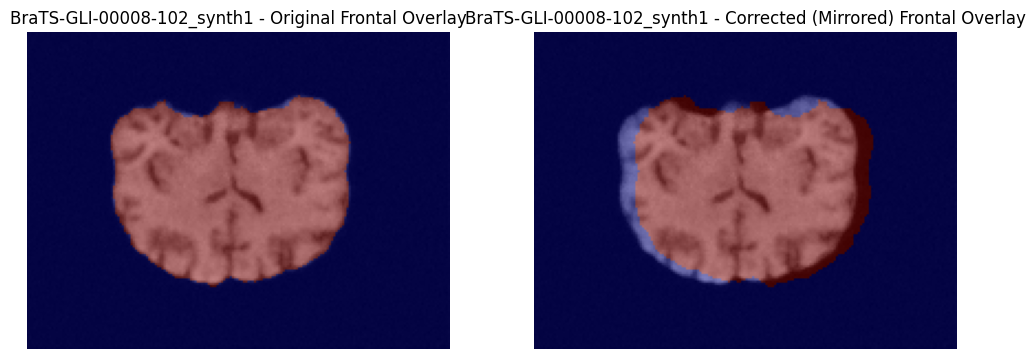

In [8]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Set paths (adjust as needed)
base_dir   = os.path.join("nnUNet", "nnUNet_raw", "Dataset005_GliHeadMaskSynthSubSetOnly")
imagesDir  = os.path.join(base_dir, "imagesTr")
labelsDir  = os.path.join(base_dir, "labelsTr")

# List segmentation files
seg_files = sorted([f for f in os.listdir(labelsDir) if f.endswith('.nii.gz')])
if not seg_files:
    raise FileNotFoundError("No segmentation files found in the directory.")

# Choose a case (e.g. the 6th case)
seg_file = seg_files[4]
case_id = seg_file[:-7]  # remove ".nii.gz"
img_file = f"{case_id}_0000.nii.gz"

img_path = os.path.join(imagesDir, img_file)
seg_path = os.path.join(labelsDir, seg_file)
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image file not found for {case_id}")

# Load and reorient to canonical (RAS)
img_obj = nib.as_closest_canonical(nib.load(img_path))
seg_obj = nib.as_closest_canonical(nib.load(seg_path))
img_data = img_obj.get_fdata()
seg_data = seg_obj.get_fdata()

# --- Extract a middle frontal (coronal) slice (fixed y, axis 1) ---
slice_idx = img_data.shape[1] // 2
img_slice = img_data[:, slice_idx, :]          # shape: (X, Z)
seg_slice_original = seg_data[:, slice_idx, :]

# --- Correct the segmentation by mirroring along the x-axis (axis 0) ---
seg_data_corrected = np.flip(seg_data, axis=0)
seg_slice_corrected = seg_data_corrected[:, slice_idx, :]

# --- Plot side-by-side ---
plt.figure(figsize=(12, 6))

# Original frontal overlay
plt.subplot(1, 2, 1)
plt.imshow(np.rot90(img_slice), cmap='gray', origin='lower')
plt.imshow(np.rot90(seg_slice_original), cmap='jet', alpha=0.5, origin='lower')
plt.title(f"{case_id} - Original Frontal Overlay")
plt.axis('off')

# Corrected (mirrored) frontal overlay
plt.subplot(1, 2, 2)
plt.imshow(np.rot90(img_slice), cmap='gray', origin='lower')
plt.imshow(np.rot90(seg_slice_corrected), cmap='jet', alpha=0.5, origin='lower')
plt.title(f"{case_id} - Corrected (Mirrored) Frontal Overlay")
plt.axis('off')

plt.show()